<a href="https://colab.research.google.com/github/Jaybhatt216/EIT/blob/main/Cushman_and_Wakefield_Lease_Renewal_Perfect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore
import shap
from collections import Counter
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans as KMean
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
import xgboost as xgb
from imblearn.over_sampling import SMOTE 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_descriptions = pd.read_csv("/content/drive/MyDrive/TV Expiration Dataset Field Defs.csv")

In [ ]:
df_descriptions

,Building_Key,Building Unique Identifier
0,SequenceNo,Lease Comp Unique Identifier
1,City,City
2,Market_Name,the C&W Market the lease transaction occurred ...
3,SubMarket_Name,the C&W SubMarket the lease transaction occurr...
4,Sublease,Tells whether the lease transaction was a subl...
5,Renewal,Tells whether the lease transaction was a renewal
6,Rent_Type,Various rental rate structures ranging from Fu...
7,Expansion_SqFt,The size of any expansion if there was expansi...
8,BuildingClass,"the class of the building. Class A is premier,..."
9,Leased_SqFt,The size of the lease transaction includes any...


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TV Expiration Dataset.csv")

In [ ]:
df.head()

,Building_Key,SequenceNo,City,Market_Name,SubMarket_Name,Sublease,Renewal,Rent_Type,Expansion_SqFt,BuildingClass,Leased_SqFt,Date_Occupied,Expiration_Date,Effective_Rent,Date_Leased,Transaction_Type,Term M,Base Rent,Industry,MM_Market
0,33271,154875,Dallas,DALLAS CBD,CBD Core,No,No,NaN,NaN,B,7123,NaN,NaN,NaN,7/1/2000,New Lease,84,17.0,Legal,Texas - Dallas/Ft Worth
1,33271,154877,Dallas,DALLAS CBD,CBD Core,No,No,NaN,NaN,B,5982,NaN,NaN,NaN,4/1/2000,New Lease,60,16.0,Legal,Texas - Dallas/Ft Worth
2,33271,154878,Dallas,DALLAS CBD,CBD Core,No,No,Full Service/Gross,NaN,B,21200,NaN,NaN,NaN,4/1/2000,NaN,36,18.0,Communications & Media,Texas - Dallas/Ft Worth
3,33271,154879,Dallas,DALLAS CBD,CBD Core,No,No,Full Service/Gross,NaN,B,2593,NaN,NaN,NaN,4/1/2000,New Lease,60,15.4,NaN,Texas - Dallas/Ft Worth
4,33271,154880,Dallas,DALLAS CBD,CBD Core,No,No,NaN,NaN,B,7123,NaN,NaN,NaN,7/1/2000,Expansion,60,16.0,Communications & Media,Texas - Dallas/Ft Worth


In [ ]:
df.shape

(107053, 20)

Building_Key 8708
SequenceNo 107053
City 245
Market_Name 57
SubMarket_Name 224
Sublease 4
Renewal 2
Rent_Type 136
Expansion_SqFt 2575
BuildingClass 3
Leased_SqFt 27704
Date_Occupied 5516
Expiration_Date 8164
Effective_Rent 6192
Date_Leased 6770
Transaction_Type 104
Term M 294
Base Rent 2943
Industry 38
MM_Market 8


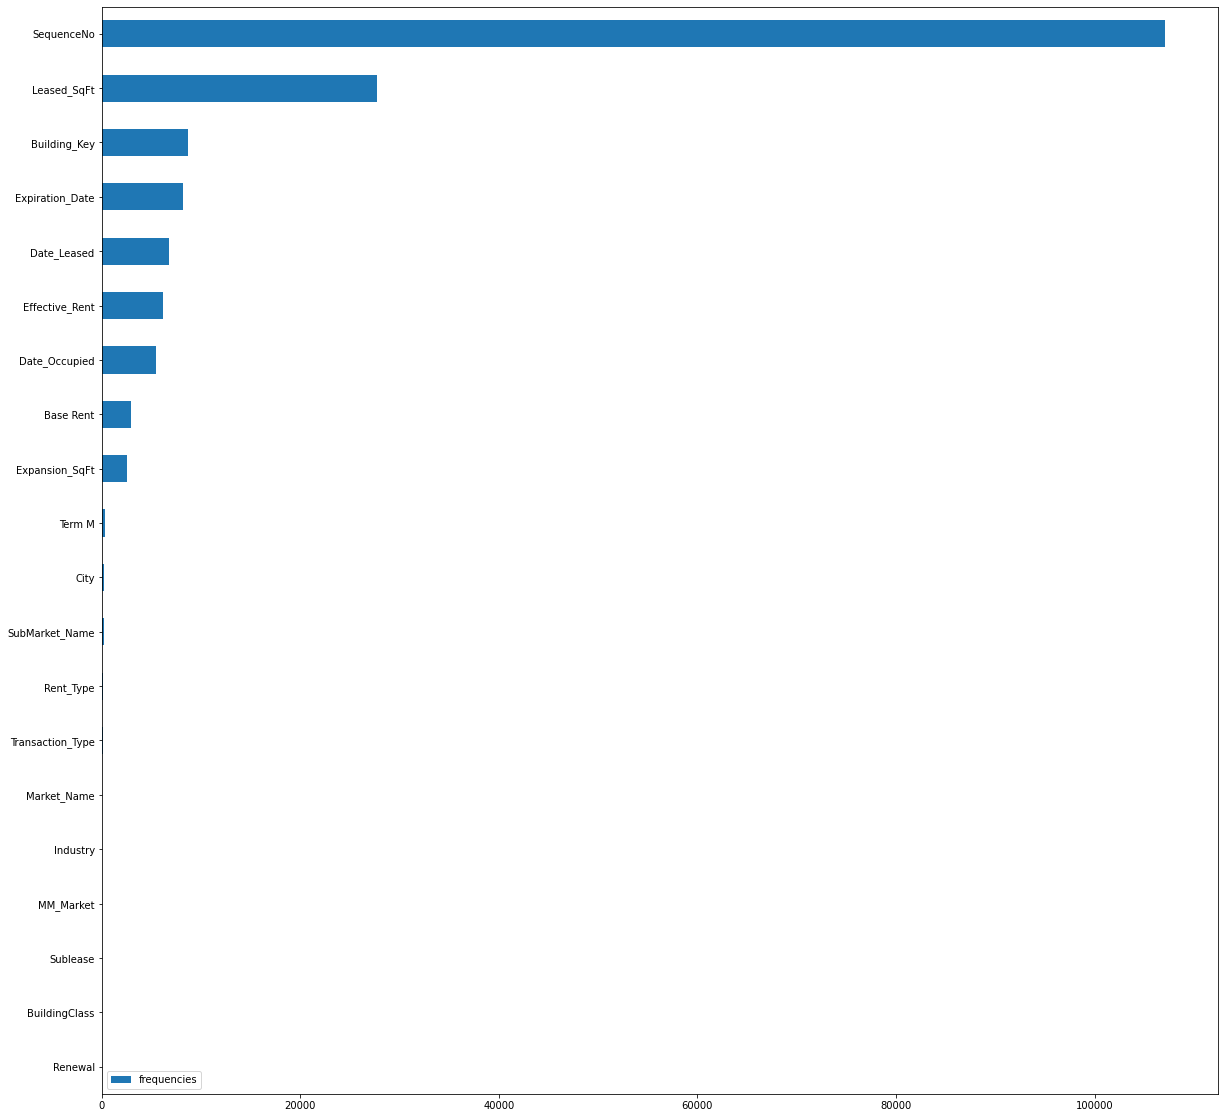

In [ ]:
frequencies = []
index = []
for col in df.columns:
  print(col, len(df[col].value_counts()))
  frequencies.append(len(df[col].value_counts()))
  index.append(col)

plotting = pd.DataFrame({"frequencies": frequencies}, index=index)
plotting = plotting.sort_values(by="frequencies")
plotting.plot(kind="barh", figsize=(20,20))
plt.savefig('/content/drive/MyDrive/cushwakeplots/frequencies.png')

### Mostly caategorical features. Sequence number is a unique identifier and should be dropped. Target is Term M, which has 294 classes. The cardinality of the target is high, so discretization will be used to lower the size of the categories.

In [ ]:
df.drop(["SequenceNo"], axis=1, inplace=True)

Building_Key 0
City 0
Market_Name 0
SubMarket_Name 0
Sublease 2937
Renewal 1296
Rent_Type 19591
Expansion_SqFt 103842
BuildingClass 0
Leased_SqFt 0
Date_Occupied 45311
Expiration_Date 34670
Effective_Rent 75011
Date_Leased 0
Transaction_Type 55104
Term M 0
Base Rent 51189
Industry 43431
MM_Market 0
                  frequencies
Building_Key             8708
SequenceNo             107053
City                      245
Market_Name                57
SubMarket_Name            224
Sublease                    4
Renewal                     2
Rent_Type                 136
Expansion_SqFt           2575
BuildingClass               3
Leased_SqFt             27704
Date_Occupied            5516
Expiration_Date          8164
Effective_Rent           6192
Date_Leased              6770
Transaction_Type          104
Term M                    294
Base Rent                2943
Industry                   38
MM_Market                   8
Building_Key                0
City                        0
Market_Nam

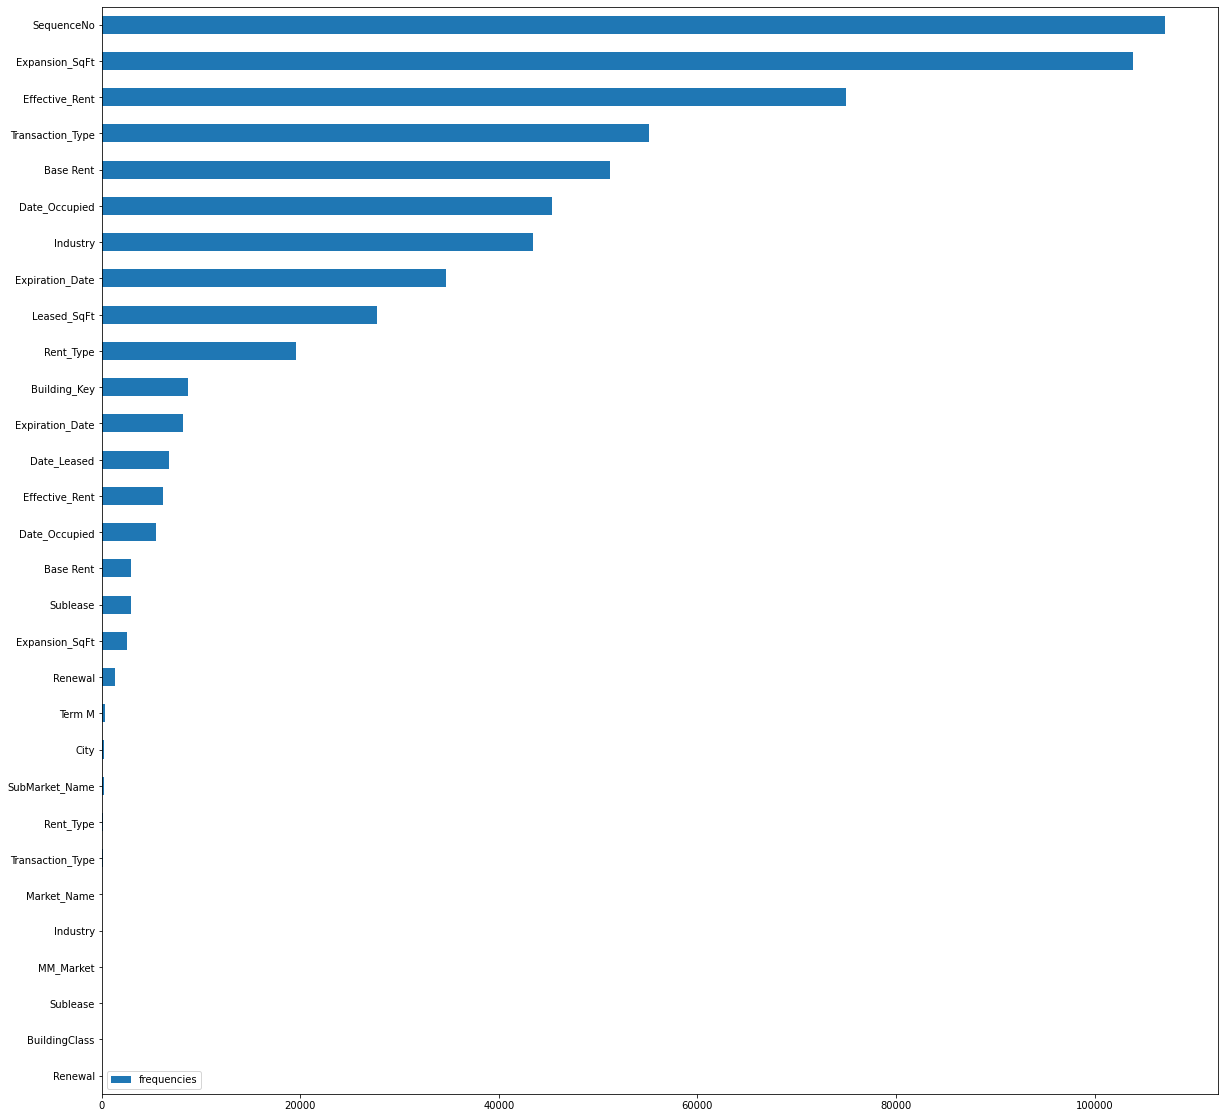

In [ ]:
for col in df.columns:
  na = df[col].isna().sum()
  print(col, na)
  frequencies.append(na)
  index.append(col)

plotting = pd.DataFrame({"frequencies": frequencies}, index=index)
print(plotting)
plotting = plotting.sort_values(by="frequencies")
plotting[plotting["frequencies"]>1].plot(kind="barh", figsize=(20,20))
plt.savefig("/content/drive/MyDrive/cushwakeplots/nulls.png")

### Expansion_SqFt has 97% null values. I will drop this column. Since columns are categorical, null will be encoded as a category in the remaining columns.

In [ ]:
103842/107053

0.9700055112888009

In [ ]:
df.drop(["Expansion_SqFt"], axis=1, inplace=True)

In [ ]:
df["Sublease"].value_counts()

No     93385
Yes    10432
 No      293
FSO        6
Name: Sublease, dtype: int64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


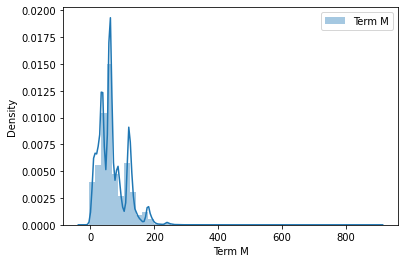

<Figure size 432x288 with 0 Axes>

In [ ]:
sb.distplot(df[df['Term M']!=0]['Term M'], label = 'Term M')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/cushwakeplots/years_dist.png')

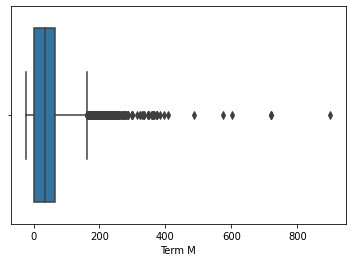

In [ ]:
sb.boxplot(x=df['Term M'])
plt.savefig('/content/drive/MyDrive/cushwakeplots/years_box.png')

In [ ]:
# Remove 0 in term M
# winsorize Term M
# convert dates to datetime and find outliers

In [ ]:
city  = df.City.value_counts().keys()
z = sorted(zscore(df["City"].value_counts()), reverse=True)

order = zip(city,z)

for city,z in order:
  print(city,z)

New York 13.953921766354883
Dallas 4.051182278554597
Chicago 3.319569857291969
San Jose 2.3035882277648057
Atlanta 2.200581424771151
Los Angeles 1.9047670161739871
Irvine 1.0388935910093728
Santa Clara 0.7642087830262925
Irving 0.6391919793929673
Palo Alto 0.5546735769366349
Plano 0.44506377375107875
Long Beach 0.41336937282995406
Mountain View 0.39884277240777194
Campbell 0.2390501677637684
Addison 0.21351856702175126
Torrance 0.18270456612621339
El Segundo 0.18270456612621339
Alpharetta 0.1791829660238662
Newport Beach 0.14792876511553493
Sunnyvale 0.128119764539832
Pasadena 0.12283736438631124
Cupertino 0.11227256407926968
Santa Monica 0.10170776377222812
Richardson 0.09554496359312055
Glendale 0.08453996327328558
Santa Ana 0.07441536297903743
Schaumburg 0.06297016264640908
Oak Brook 0.05988876255685529
Beverly Hills 0.04580236214746655
Orange 0.02643356158455703
Costa Mesa 0.018069761341482464
Frisco 0.01146676114958149
Los Altos 0.007504961034440906
Los Gatos -0.000418639195840262

In [ ]:
df0 = df[df["Term M"]==0]
df = df[df["Term M"]!=0]

In [ ]:
df0["Date_Leased"] = pd.to_datetime(df0["Date_Leased"])
df0["Expiration_Date"] = pd.to_datetime(df0["Expiration_Date"])

In [ ]:
df0["target"] = df0["Expiration_Date"] - df0["Date_Leased"]

In [ ]:
df0['target'] = df0["target"].dt.days

In [ ]:
df0['target'] = abs(round(df0["target"]/365))

In [ ]:
df["target"] = abs(round(df["Term M"]/12))

In [ ]:
df0 = df0[df0['target'].notna()]

In [ ]:
df = df.append(df0)
df.drop(["Term M", "Expiration_Date"], axis=1, inplace=True)

In [ ]:
df0['target'].isna().sum()

0

In [ ]:
df["target"].value_counts()

5.0     17591
3.0     11514
10.0     8801
2.0      6497
1.0      5350
6.0      4763
7.0      4559
4.0      3849
11.0     2915
8.0      2755
15.0     1619
12.0     1131
9.0       973
0.0       921
16.0      653
13.0      498
20.0      360
14.0      305
17.0      165
21.0       94
18.0       87
19.0       69
22.0       52
23.0       21
30.0       14
31.0       14
25.0       11
60.0       10
56.0        9
28.0        9
24.0        9
55.0        8
51.0        8
29.0        6
32.0        5
61.0        4
52.0        3
54.0        3
27.0        3
58.0        2
26.0        2
63.0        2
33.0        2
59.0        2
48.0        1
50.0        1
41.0        1
53.0        1
75.0        1
34.0        1
39.0        1
Name: target, dtype: int64

In [ ]:
df = df[df["target"] != 0]

In [ ]:
df["reg_target"] = df["target"]

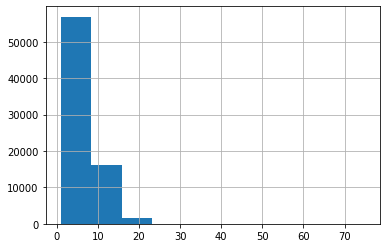

In [ ]:
df['target'].hist()

In [ ]:
df.loc[df['target'] > 10, 'target'] = 10

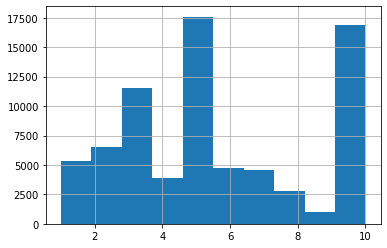

In [ ]:
df['target'].hist()
plt.savefig('/content/drive/MyDrive/cushwakeplots/capped_target.png')

In [ ]:
df["target"].value_counts()

5.0     17591
10.0    16903
3.0     11514
2.0      6497
1.0      5350
6.0      4763
7.0      4559
4.0      3849
8.0      2755
9.0       973
Name: target, dtype: int64

In [ ]:
df.loc[df["target"]==1, "target"] = 2
df.loc[df["target"]==3, "target"] = 4
df.loc[df["target"]==5, "target"] = 6
df.loc[df["target"]==7, "target"] = 8
df.loc[df["target"]==9, "target"] = 10

In [ ]:
df.loc[df["target"]==2, "target"] = 0
df.loc[df["target"]==4, "target"] = 1
df.loc[df["target"]==6, "target"] = 2
df.loc[df["target"]==8, "target"] = 3
df.loc[df["target"]==10, "target"] = 4

# Dropping Term M and Expiration Date as they both could be used to analytically determine the length of the lease.

In [ ]:
C = set(df.columns) - set(["Sublease", "Renewal", "Leased_SqFt", "BuildingClass", "Base Rent", "Effective_Rent", "MM_Market", "Term M", "Date_Leased", "Date_Occupied", "target", "reg_target"])
for c in C:
  df[c] = df[[c]].apply(lambda x: x.map(x.value_counts(normalize=True)))

In [ ]:
df.head()

,Building_Key,City,Market_Name,SubMarket_Name,Sublease,Renewal,Rent_Type,BuildingClass,Leased_SqFt,Date_Occupied,Effective_Rent,Date_Leased,Transaction_Type,Base Rent,Industry,MM_Market,target,reg_target
0,0.000294,0.080852,0.016748,0.009177,No,No,NaN,B,7123,NaN,NaN,7/1/2000,0.529031,17.0,0.111042,Texas - Dallas/Ft Worth,3.0,7.0
1,0.000294,0.080852,0.016748,0.009177,No,No,NaN,B,5982,NaN,NaN,4/1/2000,0.529031,16.0,0.111042,Texas - Dallas/Ft Worth,2.0,5.0
2,0.000294,0.080852,0.016748,0.009177,No,No,0.030996,B,21200,NaN,NaN,4/1/2000,NaN,18.0,0.068916,Texas - Dallas/Ft Worth,1.0,3.0
3,0.000294,0.080852,0.016748,0.009177,No,No,0.030996,B,2593,NaN,NaN,4/1/2000,0.529031,15.4,NaN,Texas - Dallas/Ft Worth,2.0,5.0
4,0.000294,0.080852,0.016748,0.009177,No,No,NaN,B,7123,NaN,NaN,7/1/2000,0.087740,16.0,0.068916,Texas - Dallas/Ft Worth,2.0,5.0


In [ ]:
df["Sublease"].value_counts()

No     64515
Yes     8601
 No      273
FSO        2
Name: Sublease, dtype: int64

In [ ]:
df = df[df["Sublease"]!="FSO"]

In [ ]:
df["Sublease"] = df["Sublease"].astype("str")

In [ ]:
df["Sublease"] = df[["Sublease"]].apply(lambda x: x.str.strip())

In [ ]:
df["Sublease"].value_counts()

No     64788
Yes     8601
nan     1363
Name: Sublease, dtype: int64

In [ ]:
df["Sublease"] = df["Sublease"].replace("nan", np.nan)

In [ ]:
df["Renewal"].value_counts()

No     57395
Yes    16604
Name: Renewal, dtype: int64

In [ ]:
df["BuildingClass"].value_counts()

A    43701
B    26402
C     4649
Name: BuildingClass, dtype: int64

In [ ]:
df["Market_Name"].value_counts()

0.227506    17006
0.117051     8750
0.067822     5070
0.060519     4524
0.046138     3449
0.042138     3150
0.034821     2603
0.031958     2388
0.028627     2140
0.010769     1610
0.021310     1593
0.018634     1393
0.016748     1252
0.016374     1224
0.015571     1164
0.014782     1105
0.014447     1080
0.012468      932
0.012227      914
0.012133      907
0.011973      895
0.011143      833
0.010581      791
0.009993      747
0.009979      746
0.008842      661
0.007946      594
0.007812      584
0.003839      574
0.007464      558
0.006715      502
0.005886      440
0.005832      436
0.005766      431
0.005110      382
0.004976      372
0.004829      361
0.004629      346
0.003986      298
0.003451      258
0.003411      255
0.002582      193
0.002274      170
0.002221      166
0.002127      159
0.001485      111
0.001418      106
0.001351      101
0.001324       99
0.001271       95
0.001124       84
0.000696       52
0.000669       50
0.000615       46
0.000027        2
Name: Mark

In [ ]:
df.sample(3)

,Building_Key,City,Market_Name,SubMarket_Name,Sublease,Renewal,Rent_Type,BuildingClass,Leased_SqFt,Date_Occupied,Effective_Rent,Date_Leased,Transaction_Type,Base Rent,Industry,MM_Market,target,reg_target
50555,0.000040,0.046593,0.227506,0.008842,No,No,0.168750,A,20381,12/1/2011,NaN,10/27/2011,NaN,NaN,NaN,Atlanta,4.0,10.0
26441,0.000147,0.080852,0.117051,0.018420,No,No,0.076807,A,4949,NaN,15.6,4/10/2007,NaN,NaN,0.01143,Texas - Dallas/Ft Worth,2.0,5.0
53190,0.000094,0.005779,0.028627,0.005766,No,No,0.191510,A,1237,9/1/2012,NaN,7/3/2012,0.529031,35.64,NaN,LA Metro - Los Angeles,2.0,5.0


In [ ]:
C = set(df.columns) - set(["Sublease", "Renewal", "Leased_SqFt", "BuildingClass", "Date_Occupied", "Expiration_Date", "Date_Leased", "Term M", "Effective_Rent", "Base Rent", "MM_Market", 'target', 'reg_target'])
for c in C:
  df[c] = df[c].fillna(0)

In [ ]:
df["Sublease"] = df["Sublease"].fillna("None")
df["Renewal"] = df["Renewal"].fillna("None")

In [ ]:
df["Effective_Rent"] = df.groupby("BuildingClass")["Effective_Rent"].apply(lambda x: x.fillna(x.mean()))
df["Base Rent"] = df.groupby("BuildingClass")["Base Rent"].apply(lambda x: x.fillna(x.mean()))
df["Leased_SqFt"] = df.groupby("BuildingClass")["Leased_SqFt"].apply(lambda x: x.fillna(x.mean()))

In [ ]:
df["Date_Occupied"] = df["Date_Occupied"].fillna(df["Date_Leased"])

In [ ]:
for col in df.columns:
  na = df[col].isna().sum()
  print(col, na)

Building_Key 0
City 0
Market_Name 0
SubMarket_Name 0
Sublease 0
Renewal 0
Rent_Type 0
BuildingClass 0
Leased_SqFt 0
Date_Occupied 0
Effective_Rent 0
Date_Leased 0
Transaction_Type 0
Base Rent 0
Industry 0
MM_Market 0
target 0
reg_target 0


# Dates

In [ ]:
df.head()

,Building_Key,City,Market_Name,SubMarket_Name,Sublease,Renewal,Rent_Type,BuildingClass,Leased_SqFt,Date_Occupied,Effective_Rent,Date_Leased,Transaction_Type,Base Rent,Industry,MM_Market,target,reg_target
0,0.000294,0.080852,0.016748,0.009177,No,No,0.000000,B,7123,7/1/2000,774.296923,7/1/2000,0.529031,17.0,0.111042,Texas - Dallas/Ft Worth,3.0,7.0
1,0.000294,0.080852,0.016748,0.009177,No,No,0.000000,B,5982,4/1/2000,774.296923,4/1/2000,0.529031,16.0,0.111042,Texas - Dallas/Ft Worth,2.0,5.0
2,0.000294,0.080852,0.016748,0.009177,No,No,0.030996,B,21200,4/1/2000,774.296923,4/1/2000,0.000000,18.0,0.068916,Texas - Dallas/Ft Worth,1.0,3.0
3,0.000294,0.080852,0.016748,0.009177,No,No,0.030996,B,2593,4/1/2000,774.296923,4/1/2000,0.529031,15.4,0.000000,Texas - Dallas/Ft Worth,2.0,5.0
4,0.000294,0.080852,0.016748,0.009177,No,No,0.000000,B,7123,7/1/2000,774.296923,7/1/2000,0.087740,16.0,0.068916,Texas - Dallas/Ft Worth,2.0,5.0


In [ ]:
class Winsorizer():
  def __init__(self, df):
    self.upper = df.quantile(0.95)
    self.lower = df.quantile(0.05)
    self.df = df
  def _transformer_up(self, x):
    if x > self.upper:
      return self.upper
    else:
      return x
  def _transformer_down(self, x):
    if x < self.lower:
      return self.lower
    else:
      return x
  def transform(self):
    self.df = self.df.apply(self._transformer_up)
    self.df = self.df.apply(self._transformer_down)
    return self.df


In [ ]:
win_lsqft = Winsorizer(df["Leased_SqFt"])
df["Leased_SqFt"] = win_lsqft.transform()

In [ ]:
win_br = Winsorizer(df["Base Rent"])
df["Base Rent"] = win_br.transform()

In [ ]:
win_er = Winsorizer(df["Effective_Rent"])
df["Effective_Rent"] = win_er.transform()

In [ ]:
df.loc[df['Date_Occupied'] ==20, 'Date_Occupied'] = '1/1/2020'

In [ ]:
df.loc[df["Date_Leased"]==20, 'Date_Leased'] = '1/1/2020'

In [ ]:
df["Date_Occupied"] = pd.to_datetime(df["Date_Occupied"])
df["Date_Leased"] = pd.to_datetime(df["Date_Leased"])

In [ ]:
df["Occupied_Year"] = df["Date_Occupied"].dt.year

In [ ]:
df["Occupied_Year"].sample(10)

56489     2013
106498    2020
81876     2007
51732     2012
59769     2014
80111     2010
71229     2016
82126     2007
9886      2004
37619     2008
Name: Occupied_Year, dtype: int64

In [ ]:
df["Occupied_Month"] = df["Date_Occupied"].dt.month

In [ ]:
df["Occupied_Day"] = df["Date_Occupied"].dt.day

In [ ]:
df["Leased_Year"] = df["Date_Leased"].dt.year

In [ ]:
df["Leased_Month"] = df["Date_Leased"].dt.month

In [ ]:
df["Leased_Day"] = df["Date_Leased"].dt.day

In [ ]:
df["Date_Difference"] = df["Date_Occupied"] - df["Date_Leased"]

In [ ]:
df["Date_Difference"].sample(10)

47051    61 days
90103    60 days
35033    92 days
106154   60 days
32962    31 days
102233    0 days
100309    0 days
69649     0 days
93319    90 days
47037    31 days
Name: Date_Difference, dtype: timedelta64[ns]

In [ ]:
df["Date_Difference"] = df["Date_Difference"].dt.days

In [ ]:
df["Occupied_Year"] = 2021 - df["Occupied_Year"]
df["Leased_Year"] = 2021 - df["Leased_Year"]

In [ ]:
df.drop(["Date_Occupied", "Date_Leased"], axis=1, inplace=True)

In [ ]:
df.sample(5)

,Building_Key,City,Market_Name,SubMarket_Name,Sublease,Renewal,Rent_Type,BuildingClass,Leased_SqFt,Effective_Rent,Transaction_Type,Base Rent,Industry,MM_Market,target,reg_target,Occupied_Year,Occupied_Month,Occupied_Day,Leased_Year,Leased_Month,Leased_Day,Date_Difference
95949,0.000803,0.316211,0.227506,0.027182,Yes,No,0.359697,A,24648.00,3728.369440,0.088031,104.602246,0.068916,NYC Metro,1.0,4.0,2,5,15,2,1,16,119
81114,0.002207,0.021310,0.021310,0.015691,No,Yes,0.168750,A,1303.00,39.480000,0.215236,37.800000,0.000000,NorCal - Silicon Valley,1.0,3.0,13,10,1,13,10,1,0
32567,0.000722,0.316211,0.060519,0.007572,No,No,0.359697,B,55261.95,774.296923,0.000000,40.000000,0.001332,NYC Metro,3.0,8.0,14,11,16,14,11,16,0
55056,0.000080,0.316211,0.042138,0.005043,No,Yes,0.359697,B,22000.00,774.296923,0.019706,51.000000,0.068916,NYC Metro,2.0,5.0,8,2,27,8,2,27,0
58967,0.000883,0.316211,0.227506,0.025470,No,No,0.359697,B,3446.00,774.296923,0.087740,40.000000,0.000000,NYC Metro,4.0,10.0,8,10,20,8,12,31,-72


In [ ]:
df = pd.get_dummies(df, columns=["Sublease", "Renewal", "BuildingClass", "MM_Market"])

In [ ]:
df.columns

Index(['Building_Key', 'City', 'Market_Name', 'SubMarket_Name', 'Rent_Type',
       'Leased_SqFt', 'Effective_Rent', 'Transaction_Type', 'Base Rent',
       'Industry', 'target', 'reg_target', 'Occupied_Year', 'Occupied_Month',
       'Occupied_Day', 'Leased_Year', 'Leased_Month', 'Leased_Day',
       'Date_Difference', 'Sublease_No', 'Sublease_None', 'Sublease_Yes',
       'Renewal_No', 'Renewal_None', 'Renewal_Yes', 'BuildingClass_A',
       'BuildingClass_B', 'BuildingClass_C', 'MM_Market_Atlanta',
       'MM_Market_Chicago', 'MM_Market_LA Metro - Inland Empire',
       'MM_Market_LA Metro - Los Angeles',
       'MM_Market_LA Metro - Orange County', 'MM_Market_NYC Metro',
       'MM_Market_NorCal - Silicon Valley',
       'MM_Market_Texas - Dallas/Ft Worth'],
      dtype='object')

In [ ]:
df.head()

,Building_Key,City,Market_Name,SubMarket_Name,Rent_Type,Leased_SqFt,Effective_Rent,Transaction_Type,Base Rent,Industry,target,reg_target,Occupied_Year,Occupied_Month,Occupied_Day,Leased_Year,Leased_Month,Leased_Day,Date_Difference,Sublease_No,Sublease_None,Sublease_Yes,Renewal_No,Renewal_None,Renewal_Yes,BuildingClass_A,BuildingClass_B,BuildingClass_C,MM_Market_Atlanta,MM_Market_Chicago,MM_Market_LA Metro - Inland Empire,MM_Market_LA Metro - Los Angeles,MM_Market_LA Metro - Orange County,MM_Market_NYC Metro,MM_Market_NorCal - Silicon Valley,MM_Market_Texas - Dallas/Ft Worth
0,0.000294,0.080852,0.016748,0.009177,0.000000,7123.0,774.296923,0.529031,17.0,0.111042,3.0,7.0,21,7,1,21,7,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0.000294,0.080852,0.016748,0.009177,0.000000,5982.0,774.296923,0.529031,16.0,0.111042,2.0,5.0,21,4,1,21,4,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0.000294,0.080852,0.016748,0.009177,0.030996,21200.0,774.296923,0.000000,18.0,0.068916,1.0,3.0,21,4,1,21,4,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0.000294,0.080852,0.016748,0.009177,0.030996,2593.0,774.296923,0.529031,15.4,0.000000,2.0,5.0,21,4,1,21,4,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0.000294,0.080852,0.016748,0.009177,0.000000,7123.0,774.296923,0.087740,16.0,0.068916,2.0,5.0,21,7,1,21,7,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
df.shape

(74752, 36)

#EDA

In [ ]:
df.dtypes

Building_Key                          float64
City                                  float64
Market_Name                           float64
SubMarket_Name                        float64
Rent_Type                             float64
Leased_SqFt                           float64
Effective_Rent                        float64
Transaction_Type                      float64
Base Rent                             float64
Industry                              float64
target                                float64
reg_target                            float64
Occupied_Year                           int64
Occupied_Month                          int64
Occupied_Day                            int64
Leased_Year                             int64
Leased_Month                            int64
Leased_Day                              int64
Date_Difference                         int64
Sublease_No                             uint8
Sublease_None                           uint8
Sublease_Yes                      

In [ ]:
df["Building_Key"] = df["Building_Key"].astype("float")
df["City"] = df["City"].astype("float")
df["Market_Name"] = df["Market_Name"].astype("float")
df["SubMarket_Name"] = df["SubMarket_Name"].astype("float")
df["Rent_Type"] = df["Rent_Type"].astype("float")
df["Leased_SqFt"] = df["Leased_SqFt"].astype("float")
df["Effective_Rent"] = df["Effective_Rent"].astype("float")
df["Transaction_Type"] = df["Transaction_Type"].astype("float")
df["Base Rent"] = df["Base Rent"].astype("float")
df["Industry"] = df["Industry"].astype("float")
df["target"] = df["target"].astype('int')
df["reg_target"] = df["reg_target"].astype('int')

In [ ]:
df.sample(3)

,Building_Key,City,Market_Name,SubMarket_Name,Rent_Type,Leased_SqFt,Effective_Rent,Transaction_Type,Base Rent,Industry,target,reg_target,Occupied_Year,Occupied_Month,Occupied_Day,Leased_Year,Leased_Month,Leased_Day,Date_Difference,Sublease_No,Sublease_None,Sublease_Yes,Renewal_No,Renewal_None,Renewal_Yes,BuildingClass_A,BuildingClass_B,BuildingClass_C,MM_Market_Atlanta,MM_Market_Chicago,MM_Market_LA Metro - Inland Empire,MM_Market_LA Metro - Los Angeles,MM_Market_LA Metro - Orange County,MM_Market_NYC Metro,MM_Market_NorCal - Silicon Valley,MM_Market_Texas - Dallas/Ft Worth
78688,0.000348,0.021310,0.021310,0.002876,0.168750,4501.0,19.20,0.215236,18.6,0.000000,1,3,9,7,1,9,2,29,123,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
77408,0.000094,0.001137,0.005886,0.001137,0.090946,2920.0,27.60,0.000000,25.2,0.000000,1,3,8,12,9,8,8,1,130,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
93024,0.000254,0.080852,0.117051,0.018006,0.076807,5231.0,26.61,0.529031,26.5,0.104805,2,5,3,5,1,3,5,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


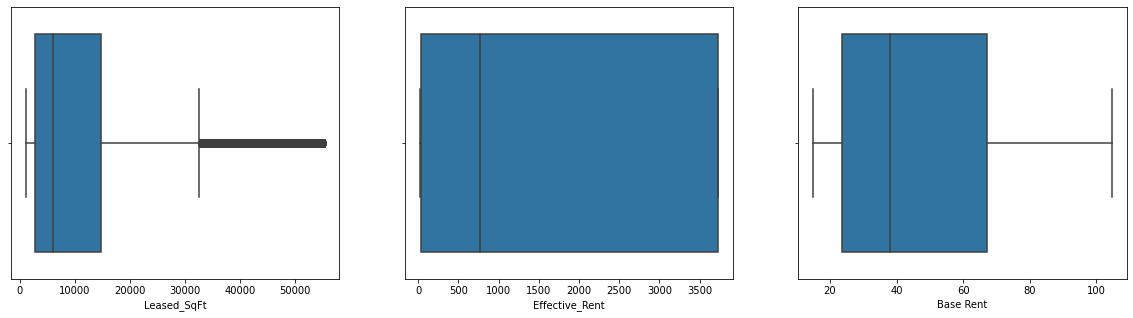

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
index = 0
axs = axs.flatten()
for k,v in df[["Leased_SqFt", "Effective_Rent", "Base Rent"]].items():
    sb.boxplot(x=k, data=df, ax=axs[index])
    plt.xlabel(k)
    index += 1

plt.savefig('/content/drive/MyDrive/cushwakeplots/numerical_dist.png')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


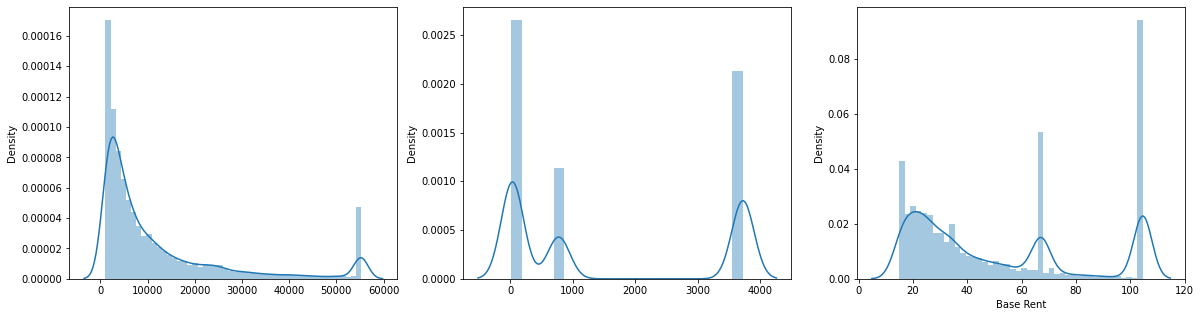

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
index = 0
axs = axs.flatten()
for k,v in df[["Leased_SqFt", "Effective_Rent", "Base Rent"]].items():
    sb.distplot(x=df[k], ax=axs[index])
    plt.xlabel(k)
    index += 1

### None of the numerical columns have normal distributions, Leased SqFt and Base Rent is close, can be log scaled. Will log scale and zscore these columns and minmax Effective Rent.
### Effective rent distplot effected by mean imputation.

In [ ]:
df["Leased_SqFt"] = np.log1p(df["Leased_SqFt"])
df["Base Rent"] = np.log1p(df["Base Rent"])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


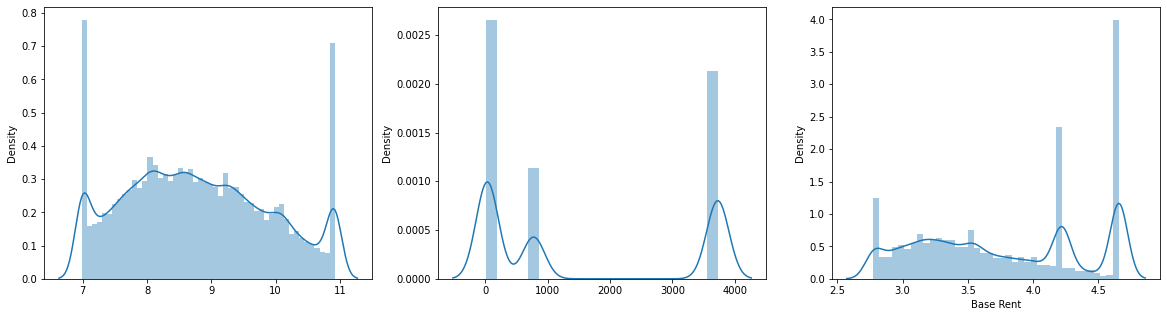

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
index = 0
axs = axs.flatten()
for k,v in df[["Leased_SqFt", "Effective_Rent", "Base Rent"]].items():
    sb.distplot(x=df[k], ax=axs[index])
    plt.xlabel(k)
    index += 1
plt.savefig('/content/drive/MyDrive/cushwakeplots/numerical_log.png')

In [ ]:
df["Leased_SqFt"] = zscore(df["Leased_SqFt"])
df["Base Rent"] = zscore(df["Base Rent"])

In [ ]:
df["Effective_Rent"] = (df["Effective_Rent"]-df["Effective_Rent"].min()) / (df["Effective_Rent"].max() - df["Effective_Rent"].min())

# Categorical Features


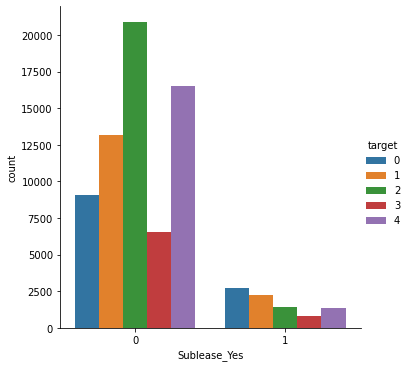

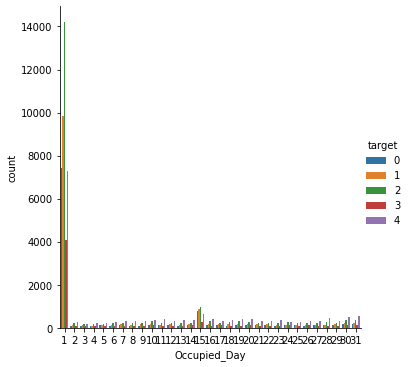

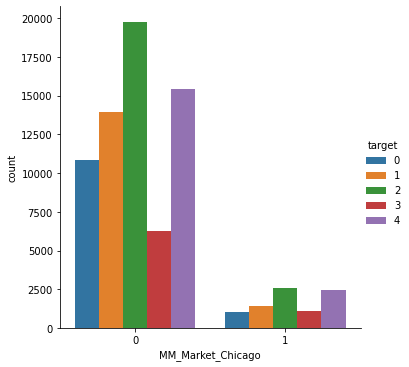

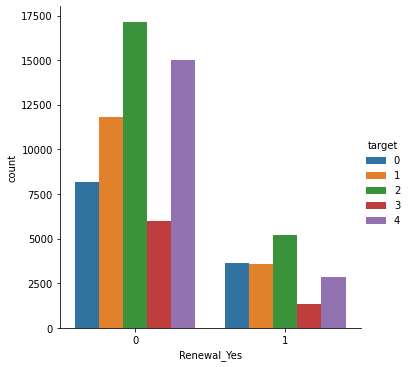

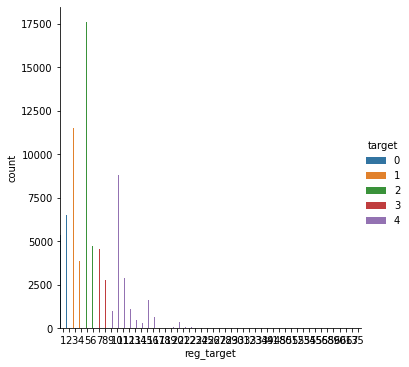

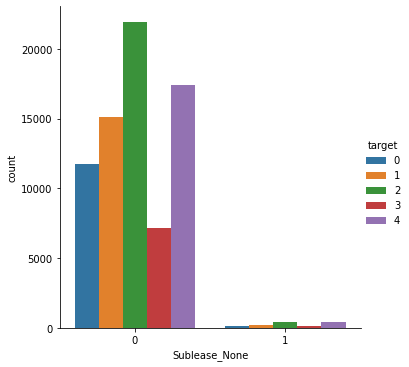

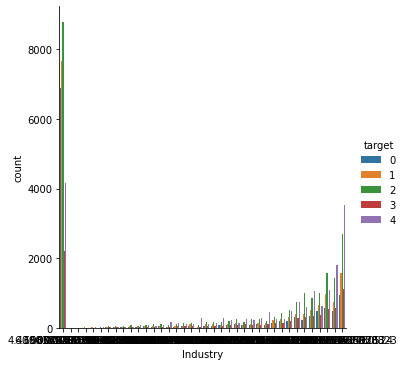

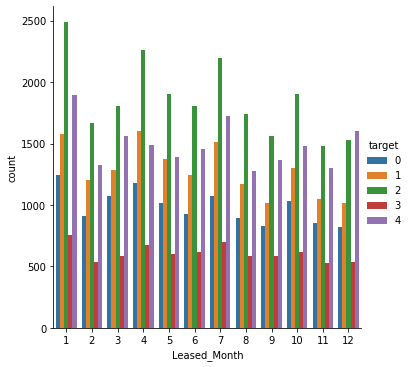

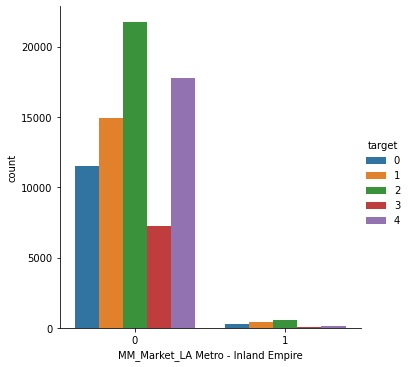

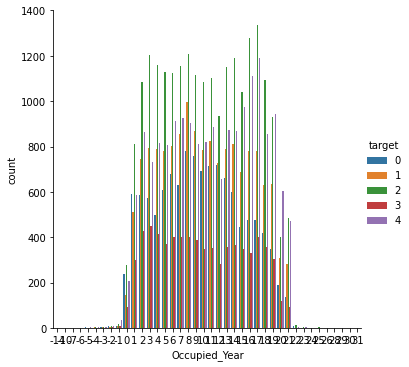

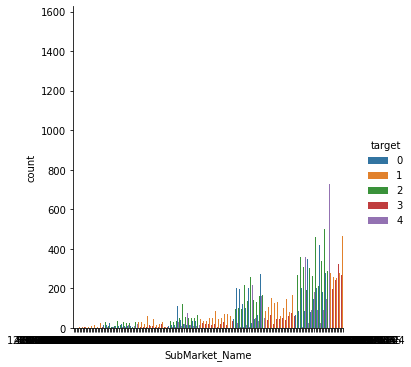

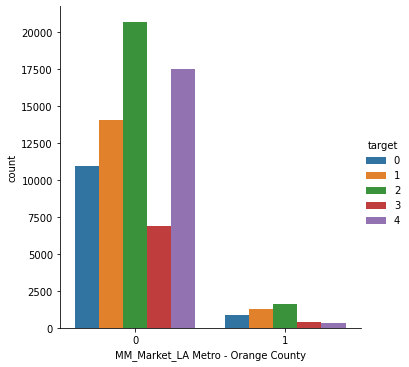

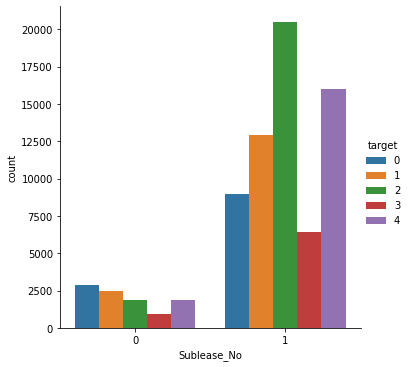

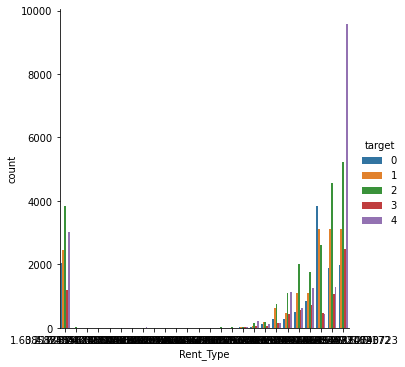

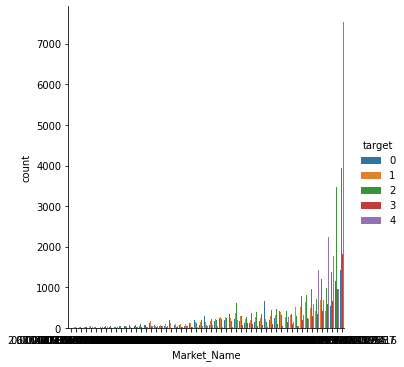

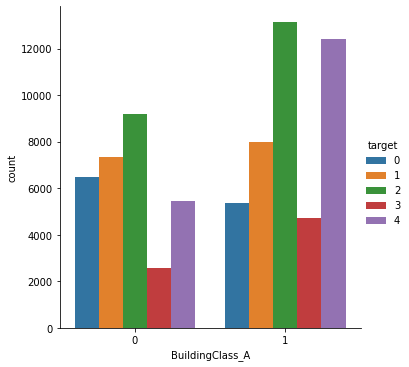

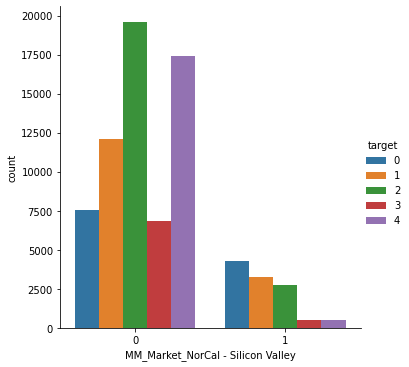

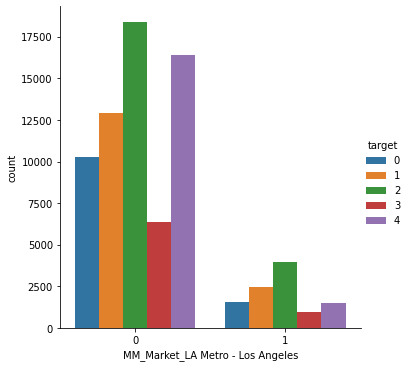

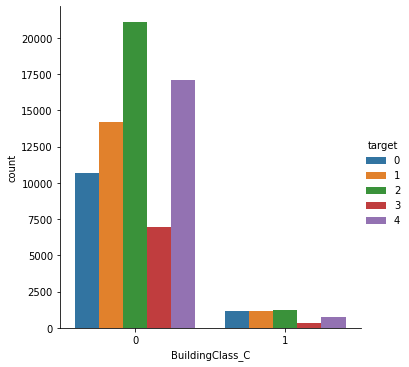

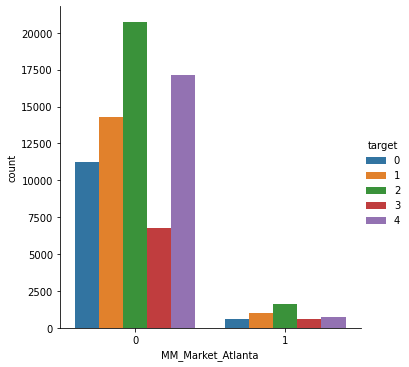

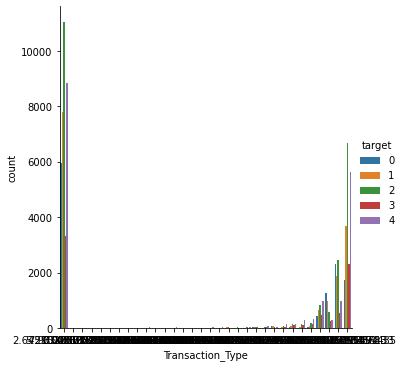

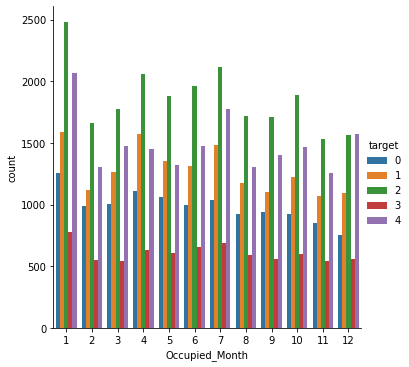

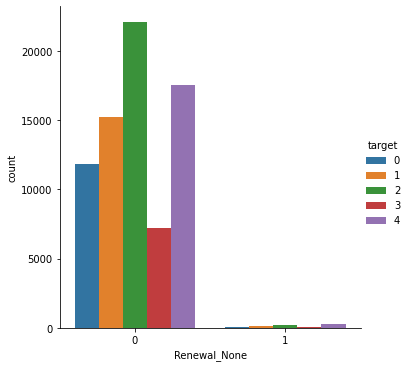

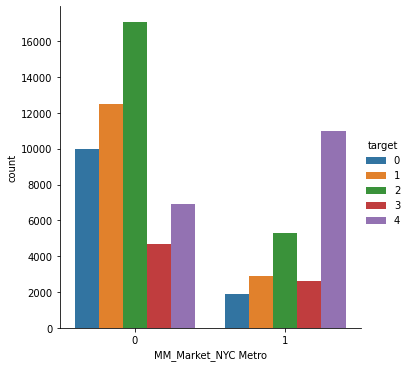

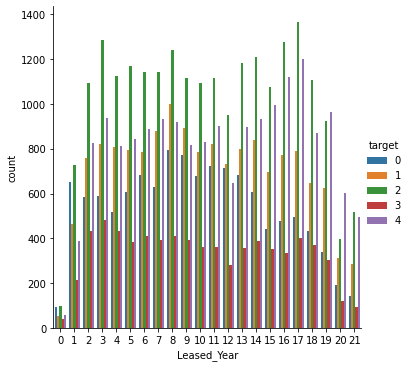

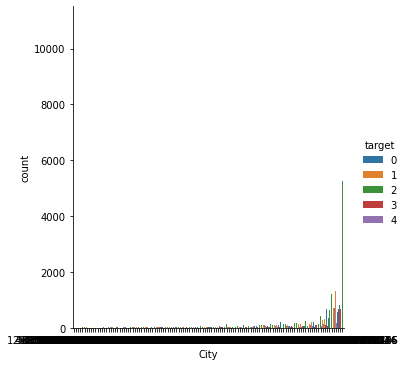

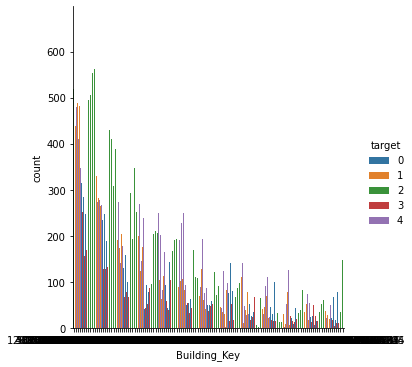

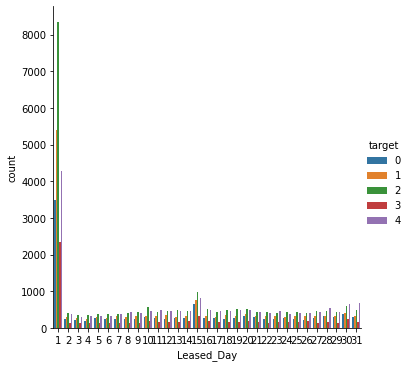

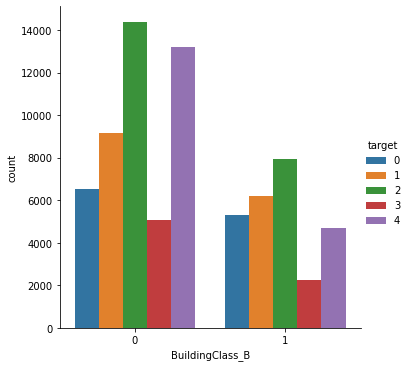

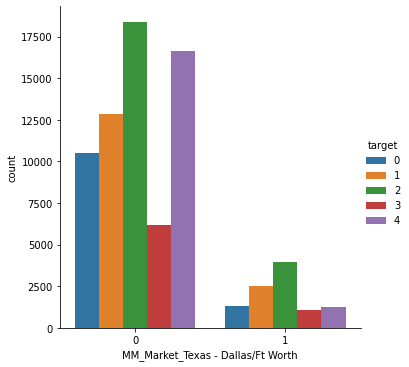

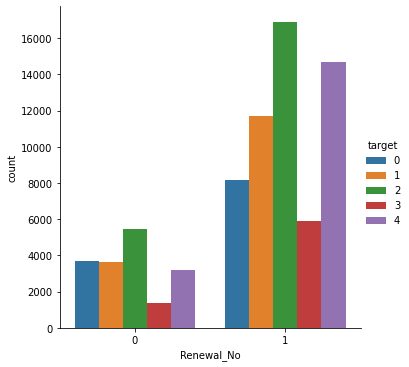

In [ ]:
for col in list(set(df.columns)-set(["Leased_SqFt", "Base Rent", "Effective_Rent", "target", "Date_Difference"])):
  sb.catplot(x=col, hue="target", data=df, kind="count")
  plt.show()
  #plt.savefig(f'/content/drive/MyDrive/cushwakeplots/cat_{col}.png')

### Now we will look at correlations using Theil's U and Pearson R.

In [ ]:
def conditional_entropy(x,y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * np.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

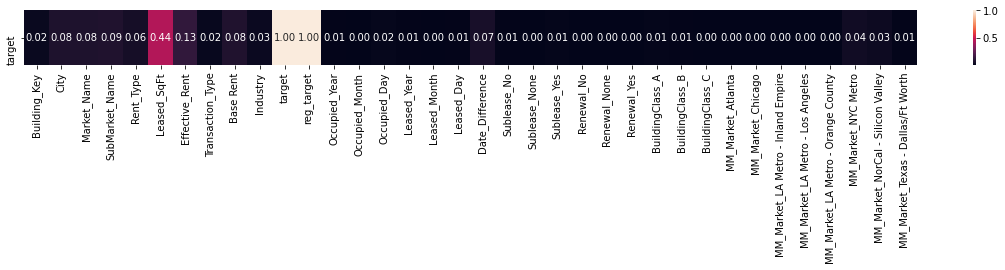

<Figure size 432x288 with 0 Axes>

In [ ]:
theilu = pd.DataFrame(index=['target'],columns=df.columns)
columns = df.columns
for j in range(0,len(columns)):
    u = theil_u(df['target'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sb.heatmap(theilu,annot=True,fmt='.2f')
plt.show()
plt.savefig('/content/drive/MyDrive/cushwakeplots/thielu.png')

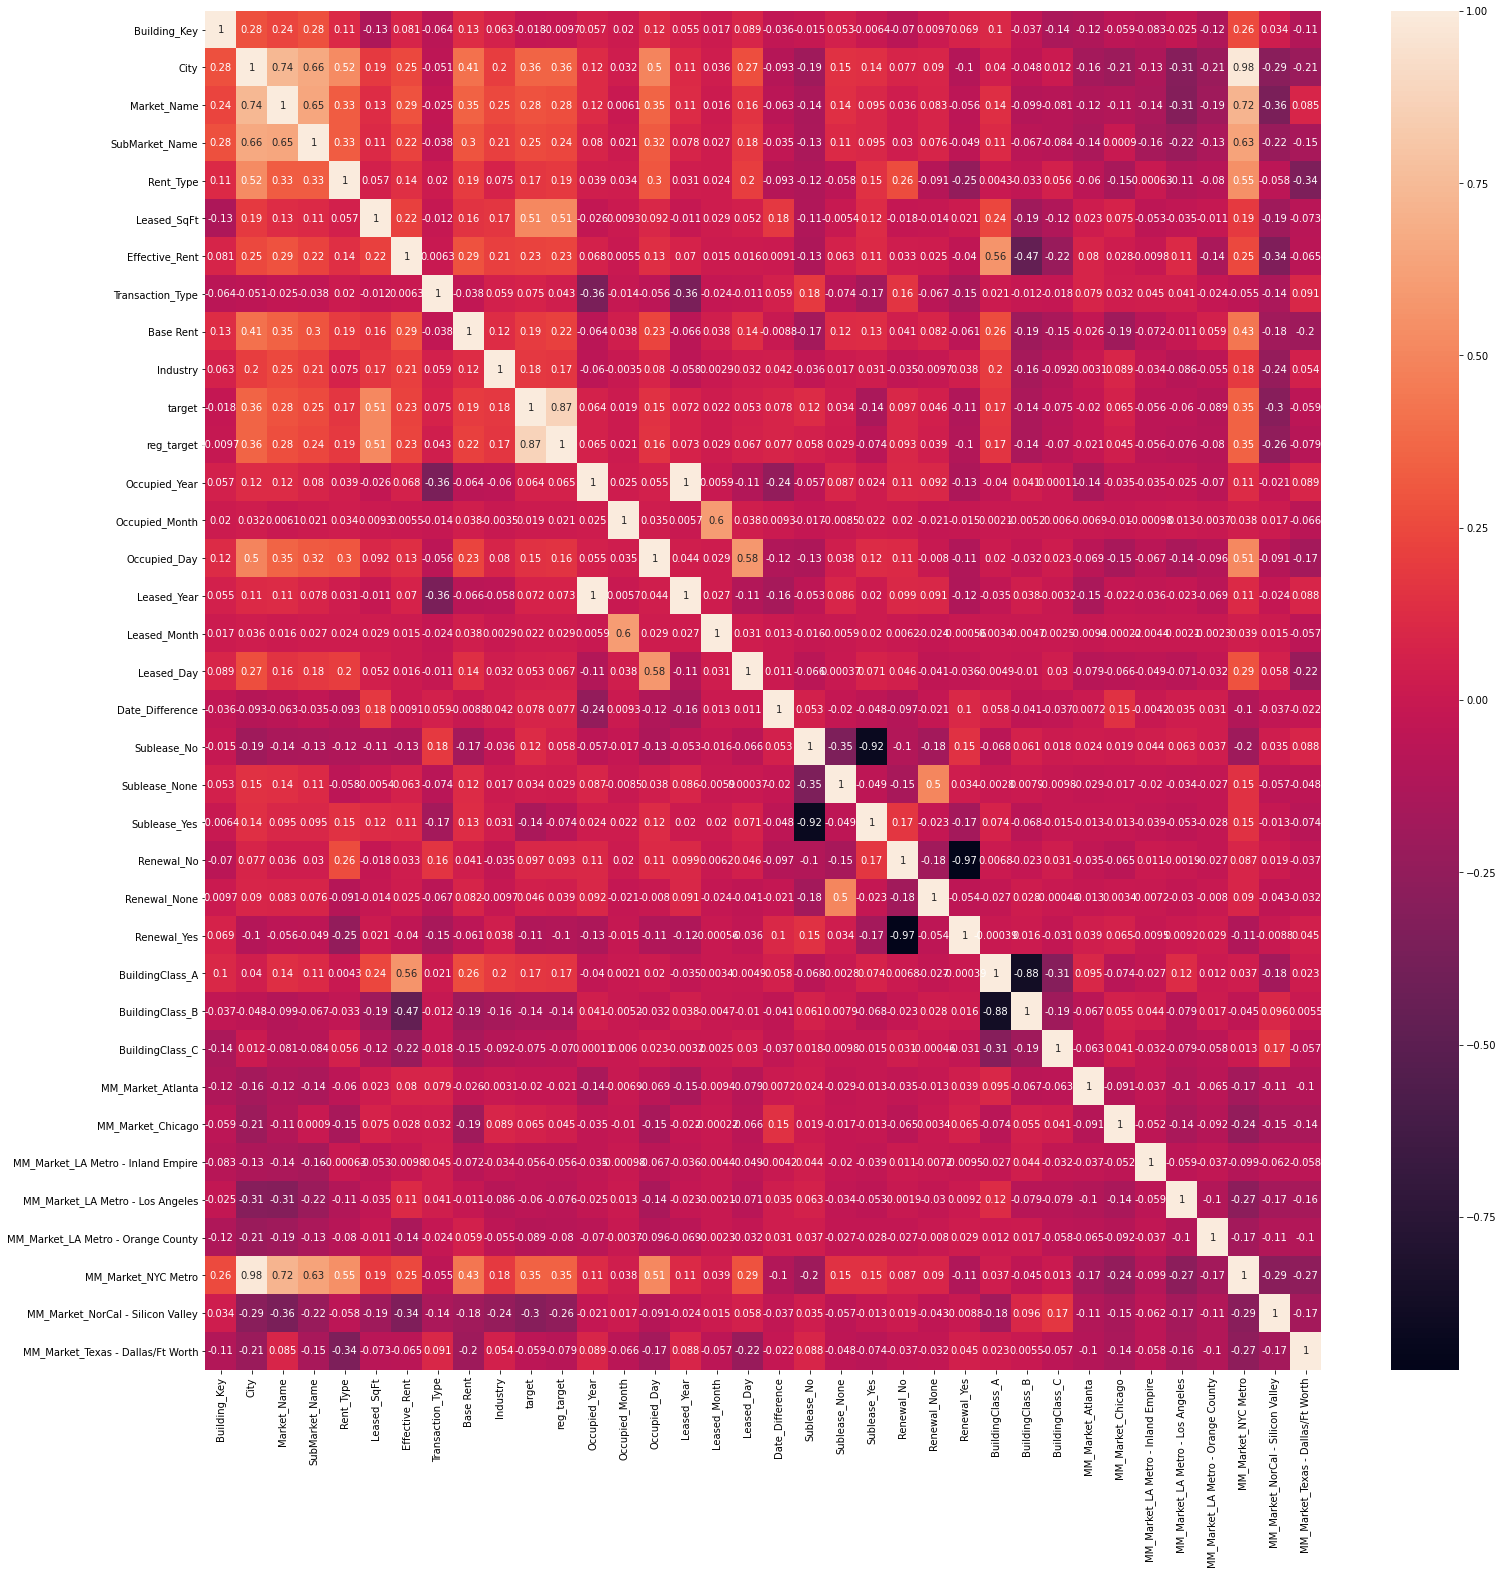

In [ ]:
plt.subplots(figsize=(25,25))
sb.heatmap(df.corr(), annot=True)
plt.savefig('/content/drive/MyDrive/cushwakeplots/corr.png')

### Minor correlation between SqFt and target, as shown by thiel u and pearson correlation. Some multicoliniarity in data, need to test p-values and variance inflation factor.

In [ ]:
np.random.seed(41)
split = np.random.uniform(0.00, 1.00, len(df))
df["split"] = split

In [ ]:
test = df[df["split"] >= 0.9].reset_index(drop=True)
df = df[df["split"] < 0.9].reset_index(drop=True)
df.drop(["split"], axis=1, inplace=True)
test.drop(["split"], axis=1, inplace=True)

In [ ]:
test = shuffle(test)
df = shuffle(df)
df.head()

,Building_Key,City,Market_Name,SubMarket_Name,Rent_Type,Leased_SqFt,Effective_Rent,Transaction_Type,Base Rent,Industry,target,reg_target,Occupied_Year,Occupied_Month,Occupied_Day,Leased_Year,Leased_Month,Leased_Day,Date_Difference,Sublease_No,Sublease_None,Sublease_Yes,Renewal_No,Renewal_None,Renewal_Yes,BuildingClass_A,BuildingClass_B,BuildingClass_C,MM_Market_Atlanta,MM_Market_Chicago,MM_Market_LA Metro - Inland Empire,MM_Market_LA Metro - Los Angeles,MM_Market_LA Metro - Orange County,MM_Market_NYC Metro,MM_Market_NorCal - Silicon Valley,MM_Market_Texas - Dallas/Ft Worth
20166,0.000763,0.316211,0.227506,0.020547,0.000000,0.282356,1.000000,0.000000,1.418494,0.219066,4,11,12,11,1,12,11,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
28465,0.001097,0.316211,0.227506,0.027182,0.359697,0.392248,1.000000,0.529031,1.223776,0.219066,4,12,8,1,1,8,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
62354,0.000883,0.316211,0.227506,0.027182,0.359697,-0.901967,1.000000,0.000000,1.442775,0.000000,2,5,17,11,8,17,11,8,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
13042,0.000321,0.048158,0.012133,0.002100,0.191510,1.281888,0.000876,0.000000,-1.232004,0.000000,4,10,19,11,15,19,11,15,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
65777,0.000268,0.316211,0.227506,0.025470,0.000000,0.819241,0.005307,0.000000,-0.099056,0.022106,4,11,10,8,30,10,8,30,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


# Clustering

# K Means Algorithm

### Euclidean Distance: $ D((a_1, b_1),(a_2, b_2)) = \sqrt {(a_1 - b_1)^2 + (a_2 - b_2)^2} $

### For data vector x and centroids C: $ argmin(c_i\in C: D(c_i, x)) $

### Finding new centroid where $ S_i $ is the set of $ s_1\ldots s_i $ clustered points and $ c_i $ is their centroid: $ c_i = (1/|S_i|)\sum_{x_i\in S_i} x_i $

In [ ]:
class KMeans:
    def __init__(self, K=2, tolerance=0.001, max_iterations=300, gamma=1e-3):
        self.K = K
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.gamma = gamma

    def fit(self, X):

        self.cent = {}

        for i in range(self.K):

            self.cent[i] = X[i]

        for i in range(self.max_iterations):
            self.clf = {}

            for i in range(self.K):
                self.clf[i] = []

            for features in X:
                distance = [np.linalg.norm(features-self.cent[centroid]) for centroid in self.cent]
                classification = distance.index(min(distance))
                self.clf[classification].append(features)

            prev_cent = dict(self.cent)

            for classification in self.clf:
                self.cent[classification] = np.average(self.clf[classification],axis=0)

            optimized = True

            for c in self.cent:

                prev_centroids = dict(self.cent)

                original_centroid = prev_cent[c]
                current_centroid = self.cent[c]
                if np.sum((current_centroid-original_centroid)/(original_centroid + self.gamma)*100.0) > self.tolerance:
                    optimized = False

            if optimized:
                break

    def predict(self, X):
        clf = []
        for i in range(len(X)):
          distance = [np.linalg.norm(X[i]-self.cent[centroid]) for centroid in self.cent]
          clf.append(np.argmin(np.array(distance)))
        return clf

In [ ]:
dfk = df.drop(["target", "reg_target"], axis=1)
testk = test.drop(["target", "reg_target"], axis=1)

km = KMeans(K=8, tolerance=0.001, max_iterations=1000, gamma=1e-6)
km.fit(dfk.to_numpy())
k_df = km.predict(dfk.to_numpy())
df["kmeans"] = k_df
k_t = km.predict(testk.to_numpy())
test["kmeans"] = k_t
plt.savefig('/content/drive/MyDrive/cushwakeplots/km_dist.png')

<Figure size 432x288 with 0 Axes>

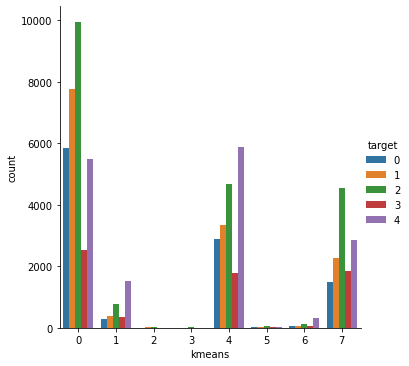

In [ ]:
sb.catplot(x="kmeans", hue="target", data=df, kind="count")
plt.savefig('/content/drive/MyDrive/cushwakeplots/km_freq.png')

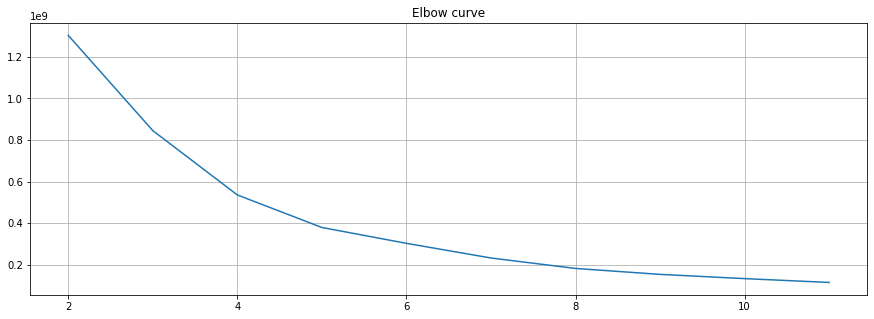

In [ ]:
distorsions = []
for k in range(2, 12):
    kmean = KMean(n_clusters=k)
    kmean.fit(dfk)
    distorsions.append(kmean.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 12), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.savefig('/content/drive/MyDrive/cushwakeplots/no_elbow.png')

# Feature Importances

In [ ]:
Y = df["target"]
X = df.drop(["target", "reg_target"], axis=1)
test_y = test["target"]
test_X = test.drop(["target", "reg_target"], axis=1)
print(X.columns, test_X.columns)

Index(['Building_Key', 'City', 'Market_Name', 'SubMarket_Name', 'Rent_Type',
       'Leased_SqFt', 'Effective_Rent', 'Transaction_Type', 'Base Rent',
       'Industry', 'Occupied_Year', 'Occupied_Month', 'Occupied_Day',
       'Leased_Year', 'Leased_Month', 'Leased_Day', 'Date_Difference',
       'Sublease_No', 'Sublease_None', 'Sublease_Yes', 'Renewal_No',
       'Renewal_None', 'Renewal_Yes', 'BuildingClass_A', 'BuildingClass_B',
       'BuildingClass_C', 'MM_Market_Atlanta', 'MM_Market_Chicago',
       'MM_Market_LA Metro - Inland Empire',
       'MM_Market_LA Metro - Los Angeles',
       'MM_Market_LA Metro - Orange County', 'MM_Market_NYC Metro',
       'MM_Market_NorCal - Silicon Valley',
       'MM_Market_Texas - Dallas/Ft Worth', 'kmeans'],
      dtype='object') Index(['Building_Key', 'City', 'Market_Name', 'SubMarket_Name', 'Rent_Type',
       'Leased_SqFt', 'Effective_Rent', 'Transaction_Type', 'Base Rent',
       'Industry', 'Occupied_Year', 'Occupied_Month', 'Occupied_Day',

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
explainer = shap.Explainer(lr, X, feature_names=X.columns)
shap_values = explainer(test_X)

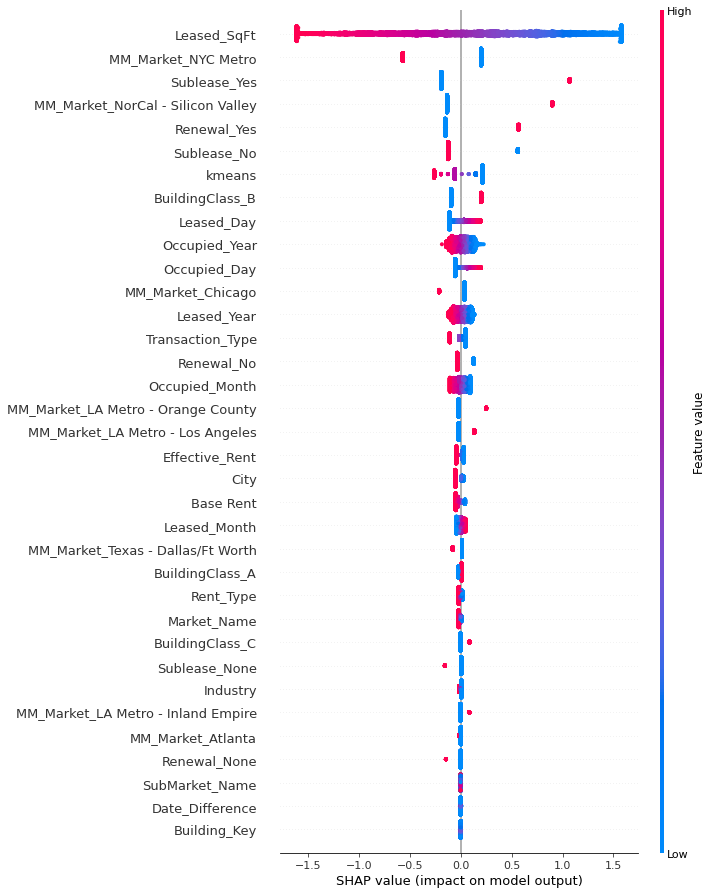

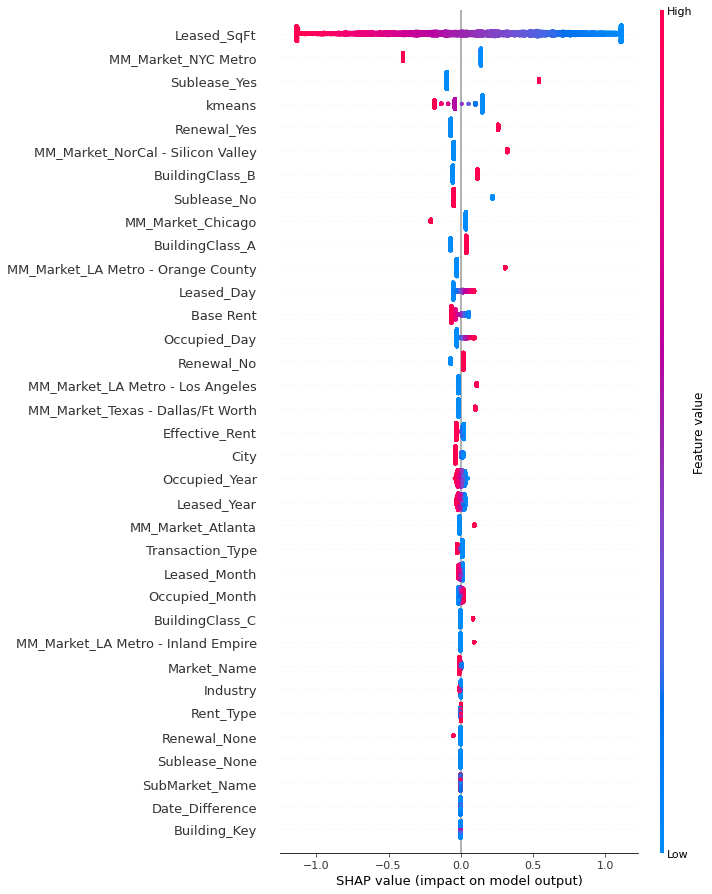

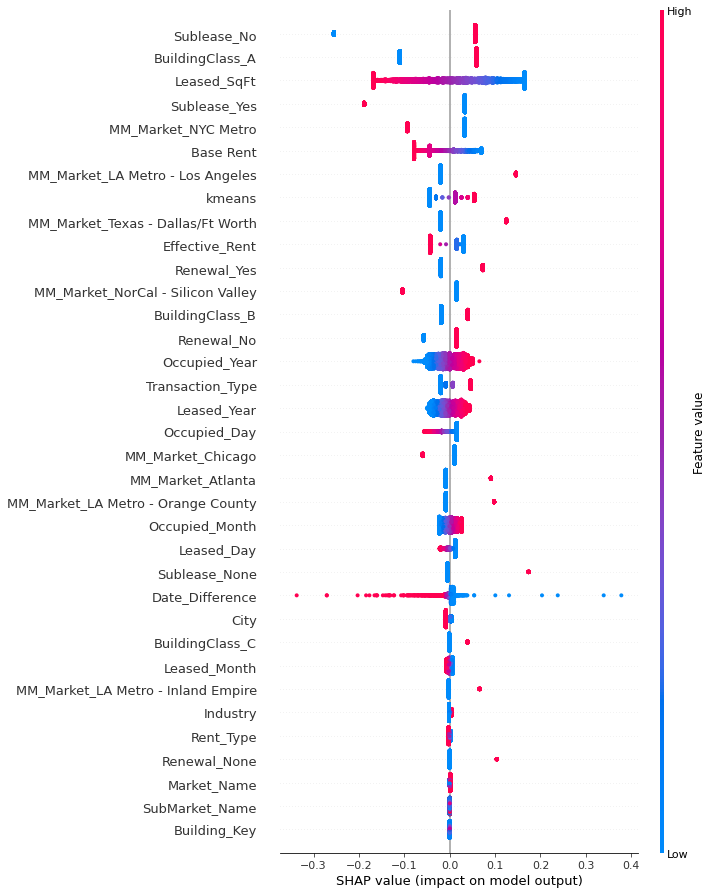

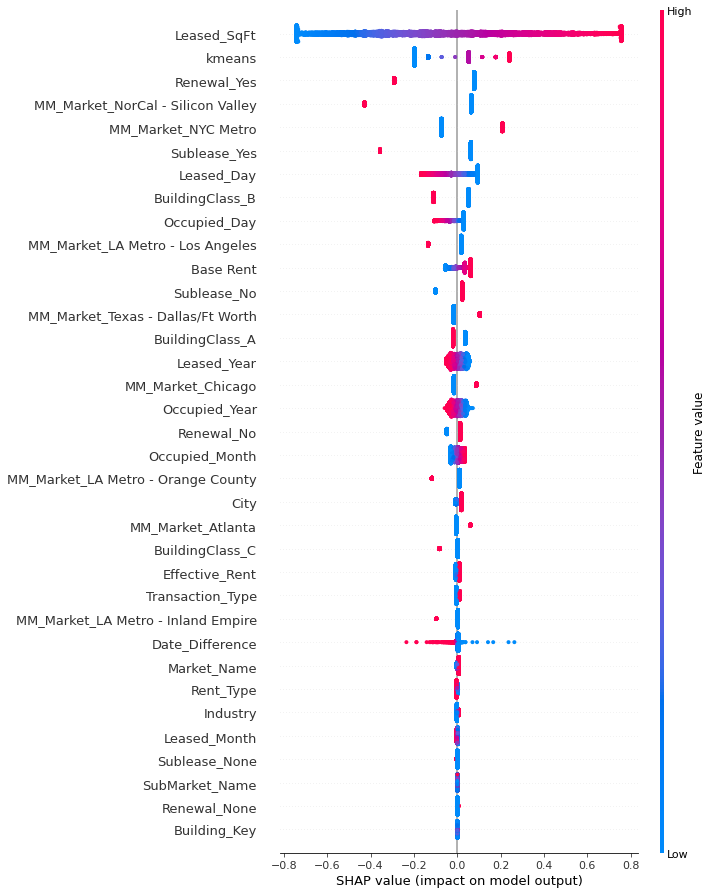

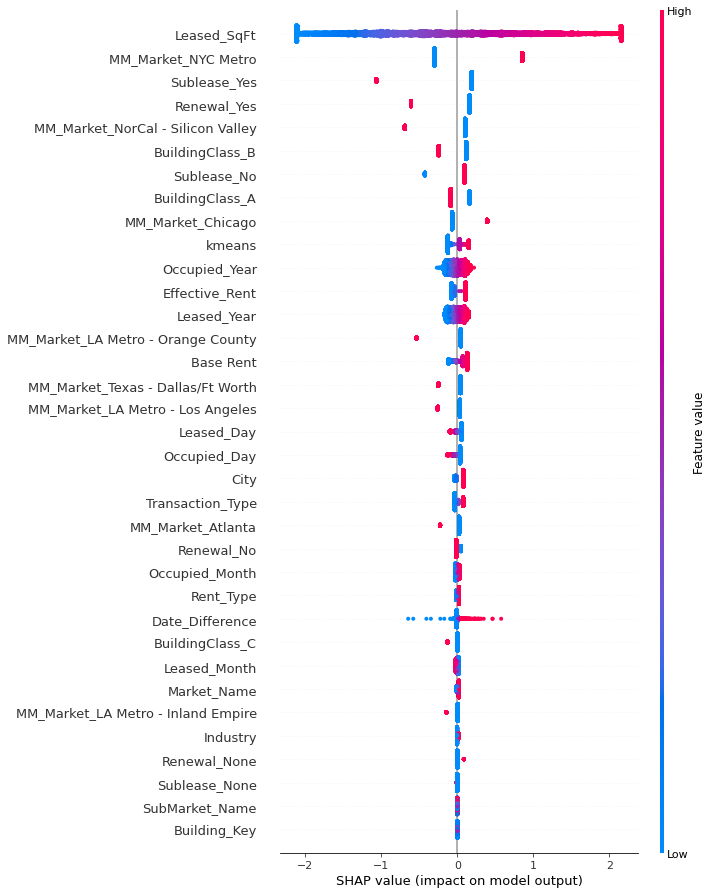

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(5):
  shap.plots.beeswarm(shap_values[:,:,i],  max_display=100)
  plt.savefig(f'/content/drive/MyDrive/cushwakeplots/shap_{i}.png')

### Unimportant Features: Building_Key, Submarket Name, Renewal_None, Market Name, Industry, MM_Market_LA - Inland, Sublease_None, Rent Type, MM_Market-ATL

In [ ]:
df.drop(["Building_Key", "SubMarket_Name", "Renewal_None", "Market_Name", "Industry", "MM_Market_LA Metro - Inland Empire", "Sublease_None", "Rent_Type", "MM_Market_Atlanta"], axis=1, inplace=True)
test.drop(["Building_Key", "SubMarket_Name", "Renewal_None", "Market_Name", "Industry", "MM_Market_LA Metro - Inland Empire", "Sublease_None", "Rent_Type", "MM_Market_Atlanta"], axis=1, inplace=True)

In [ ]:
df_vif = df.drop(["target"], axis=1)
vif = pd.Series([variance_inflation_factor(df_vif.to_numpy(), i) for i in range(df_vif.shape[1])], index=df_vif.columns)
vif

City                                  3.849520e+01
Leased_SqFt                           1.517162e+00
Effective_Rent                        1.823150e+00
Transaction_Type                      1.334037e+00
Base Rent                             1.447175e+00
reg_target                            1.653980e+00
Occupied_Year                         1.286941e+07
Occupied_Month                        3.210405e+04
Occupied_Day                          2.746277e+02
Leased_Year                           1.240729e+07
Leased_Month                          3.194236e+04
Leased_Day                            3.060651e+02
Date_Difference                       9.496530e+04
Sublease_No                           8.933212e+00
Sublease_Yes                          8.675612e+00
Renewal_No                            2.460252e+01
Renewal_Yes                           2.414075e+01
BuildingClass_A                       8.382815e+01
BuildingClass_B                       4.952360e+01
BuildingClass_C                

### VIF of Effective_Rent, Base Rent, and Leased_SqFt are all under 10.

# 5-Fold Cross-Validation

In [ ]:
fold = np.random.randint(0,5,len(df))
df["fold"] = fold

In [ ]:
def split(data, fold_num):
    fold = fold_num
    X_train = df[df["fold"] != fold].reset_index(drop=True)
    X_test = df[df["fold"] == fold].reset_index(drop=True)
    y_train = X_train["target"]
    y_test = X_test["target"]

    X_train.drop(["target", "reg_target"], axis=1, inplace=True)
    X_test.drop(["target", "reg_target"], axis=1, inplace=True)


    X_train.drop(["fold"], axis=1, inplace=True)
    X_test.drop(["fold"], axis=1, inplace=True)

    return (X_train, y_train, X_test, y_test)
#X_train, y_train, X_test, y_test = split(df, 0)

#Model Building: Feed Forward Neural Network, XGBoost

In [ ]:
sm = SMOTE(random_state=42, k_neighbors=10)
X_train, y_train = sm.fit_resample(X_train, y_train)
np.bincount(y_train)

In [ ]:
y_train[0:5]

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_test.value_counts()

In [ ]:
pd.get_dummies(y_train).to_numpy().shape

In [ ]:
nn = Sequential([
        layers.Dense(26, input_dim=26, activation="tanh"),
        layers.Dense(5, activation="softmax")
    ])

In [ ]:
nn.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.Adam(learning_rate=0.005), metrics=['categorical_accuracy', 'Precision', 'Recall', tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')])

In [ ]:
nn.fit(
        X_train,
        pd.get_dummies(y_train),
        batch_size=64,
        epochs=50,
        validation_data=(X_test.to_numpy(), pd.get_dummies(y_test).to_numpy()),
        use_multiprocessing=True,
        verbose=1,
        # callbacks=my_callbacks
    )

In [ ]:
nn.evaluate(X_test.to_numpy(), pd.get_dummies(y_test).to_numpy())

In [ ]:
y_test.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test.to_numpy(), label=y_test.to_numpy())
evallist = [(test, 'eval'), (train, 'train')]

RANDOM_STATE = 2016
param = {
    "tree_method": "gpu_hist",
    "objective": "multi:softmax",
    "nthread": -1,
    "num_class": 6,
    "eval_metric": "mlogloss",
    'min_child_weight': 3,
    'eta': 0.001,
    'colsample_bytree': 0.6,
    'max_depth': 6,
    'subsample': 0.6,
    'alpha': 2,
    'gamma': 2,
    'silent': 1,
    'verbose_eval': True,
    'seed': RANDOM_STATE
}

num_round = 1100
bst = xgb.train(param, train, num_round, evallist, early_stopping_rounds=50)

In [ ]:
y_hat = bst.predict(test)

In [ ]:
y_test.value_counts()

In [ ]:
def scores(y_test, y_hat):
  acc = accuracy_score(y_test, y_hat)
  prec = precision_score(y_test, y_hat, average="macro")
  rec = recall_score(y_test, y_hat, average="macro")
  roc = roc_auc_score(pd.get_dummies(y_test).to_numpy(), pd.get_dummies(y_hat).to_numpy(), multi_class="ovr", average='macro')
  print("Accuracy:", acc)
  print("Precision:", prec)
  print("Recall:", rec)
  print("ROC AUC:", roc)

In [ ]:
scores(y_test, y_hat)

In [ ]:
sb.heatmap(confusion_matrix(y_test, y_hat), annot=True)

# Regression

In [ ]:
def split_reg(data, fold_num):
    fold = fold_num
    X_train = df[df["fold"] != fold].reset_index(drop=True)
    X_test = df[df["fold"] == fold].reset_index(drop=True)
    y_train = X_train["reg_target"]
    y_test = X_test["reg_target"]

    X_train.drop(["target", "reg_target"], axis=1, inplace=True)
    X_test.drop(["target", "reg_target"], axis=1, inplace=True)


    X_train.drop(["fold"], axis=1, inplace=True)
    X_test.drop(["fold"], axis=1, inplace=True)

    return (X_train, y_train, X_test, y_test)
#X_train, y_train, X_test, y_test = split_reg(df, 0)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)
evallist = [(test, 'eval'), (train, 'train')]

RANDOM_STATE = 2016
param = {
    "tree_method": "gpu_hist",
    "objective": "reg:squarederror",
    "nthread": -1,
    "eval_metric": "rmse",
    'min_child_weight': 3,
    'eta': 0.001,
    'colsample_bytree': 0.6,
    'max_depth': 6,
    'subsample': 0.6,
    'alpha': 2,
    'gamma': 2,
    'silent': 1,
    'verbose_eval': True,
    'seed': RANDOM_STATE
}

num_round = 1100
bst = xgb.train(param, train, num_round, evallist, early_stopping_rounds=50)

In [ ]:
y_hat = bst.predict(test)

In [ ]:
def reg_scores(y_test, y_hat):
  mse = mean_squared_error(y_test, y_hat, squared=False)
  mae = mean_absolute_error(y_test, y_hat)
  print("MSE:", mse)
  print("MAE:", mae)

In [ ]:
reg_scores(y_test, y_hat)

In [ ]:
def xg_loop(df):
  scores = []
  for i in range(5):
    X_train, y_train, X_test, y_test = split_reg(df, i)
    train = xgb.DMatrix(X_train, label=y_train)
    test = xgb.DMatrix(X_test, label=y_test)
    evallist = [(test, 'eval'), (train, 'train')]

    RANDOM_STATE = 2016
    param = {
        "tree_method": "gpu_hist",
        "objective": "reg:squarederror",
        "nthread": -1,
        "eval_metric": "rmse",
        'min_child_weight': 3,
        'eta': 0.001,
        'colsample_bytree': 0.6,
        'max_depth': 6,
        'subsample': 0.6,
        'alpha': 2,
        'gamma': 2,
        'silent': 1,
        'verbose_eval': True,
        'seed': RANDOM_STATE
    }

    num_round = 1100
    bst = xgb.train(param, train, num_round, evallist, early_stopping_rounds=50) 
    y_hat = bst.predict(test)
    mse = mean_squared_error(y_test, y_hat, squared=False)
    mae = mean_absolute_error(y_test, y_hat) 
    scores.append([mae, mse])
  return scores

In [ ]:
scores = xg_loop(df)
scores

In [ ]:
for i in range(5):
  print(f"MAE {i}:", scores[i][0])
  print(f"RMSE {i}:", scores[i][1])

In [ ]:
nn = Sequential([
        layers.Dense(26, input_dim=26, activation="tanh"),
        layers.Dense(1, activation=None)
    ])

In [ ]:
nn.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.005), metrics=['mae', 'mse'])

In [ ]:
nn.fit(
        X_train.to_numpy(),
        y_train.to_numpy(),
        batch_size=64,
        epochs=100,
        validation_data=(X_test.to_numpy(), y_test.to_numpy()),
        use_multiprocessing=True,
        verbose=1,
        # callbacks=my_callbacks
    )

In [ ]:
nn.evaluate(X_test.to_numpy(), y_test.to_numpy())

In [ ]:
np.sqrt(9.6546)

In [ ]:
def cross_val_train(df):
  scores = []
  for i in range(5):
    X_train, y_train, X_test, y_test = split_reg(df, i)
    model = Sequential([
        layers.Dense(27, input_dim=27, activation="tanh"),
        layers.Dense(1, activation=None)
    ])
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.005), metrics=['mae', 'mse'])
    model.fit(
        X_train.to_numpy(),
        y_train.to_numpy(),
        batch_size=64,
        epochs=50,
        validation_data=(X_test.to_numpy(), y_test.to_numpy()),
        use_multiprocessing=True,
        verbose=1,
        # callbacks=my_callbacks
    )
    scores.append(model.evaluate(X_test.to_numpy(), y_test.to_numpy()))
  return scores

In [ ]:
scores = cross_val_train(df)

In [ ]:
scores

In [ ]:
for i in range(5):
  print(f"MAE {i}:", scores[i][1])
  print(f"RMSE {i}:", np.sqrt(scores[i][2]))
  print("--------------------------------")

### Winsorizing the target.

In [ ]:
wz = Winsorizer(df["reg_target"])
df["reg_target"] = wz.transform()

In [ ]:
scores = cross_val_train(df)

In [ ]:
for i in range(5):
  print(f"MAE {i}:", scores[i][1])
  print(f"RMSE {i}:", np.sqrt(scores[i][2]))
  print("--------------------------------")

In [ ]:
scores = xg_loop(df)

In [ ]:
for i in range(5):
  print(f"MAE {i}:", scores[i][0])
  print(f"RMSE {i}:", scores[i][1])

# Market Segmentation Model

[9.90976520e-01 4.81858989e-03 1.95723035e-03 1.16065823e-03
 5.76657476e-04 1.86464551e-04 1.44941269e-04 6.07572095e-05
 3.70914730e-05 2.49377361e-05 1.32544371e-05 1.04993265e-05
 5.98535447e-06 5.43746704e-06 4.61939209e-06 4.01721470e-06
 3.47276294e-06 2.88846074e-06 2.31776700e-06 1.77585842e-06]


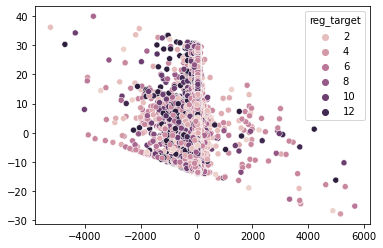

In [ ]:
df_pca = df.copy()
df_pca.drop(["target", "reg_target"], axis=1, inplace=True)
pca = PCA(n_components=20)
eigen_vectors = pca.fit_transform(df_pca)
print(pca.explained_variance_ratio_)
sb.scatterplot(x=eigen_vectors[:,0], y=eigen_vectors[:,1], hue=df["reg_target"])
plt.savefig('/content/drive/MyDrive/cushwakeplots/eigenvectors.png')

In [ ]:
df["pca"] = eigen_vectors[:,0]

In [ ]:
#MM_Market_NorCal - Silicon Valley 1804
#MM_Market_Chicago 1506
#MM_Market_NYC Metro 
#MM_Market_Texas - Dallas/Ft Worth 
#MM_Market_LA Metro - Orange County
#MM_Market_LA Metro - Los Angeles 
test = df[["target", reg_target]]
df.drop(["target", "reg_target"], axis=1, inplace=True)



df_NorCal = df[df["MM_Market_NorCal - Silicon Valley"]==1].copy()
df_Chicago = df[df["MM_Market_Chicago"]==1].copy()
df_NYC = df[df["MM_Market_NYC Metro"]==1].copy()
df_DFW = df[df["MM_Market_Texas - Dallas/Ft Worth"]==1].copy()
df_OC = df[df["MM_Market_LA Metro - Orange County"]==1].copy()
df_LA = df[df["MM_Market_LA Metro - Los Angeles"]==1].copy()
df_Other = df[(df["MM_Market_NorCal - Silicon Valley"]==0) & (df["MM_Market_Chicago"]==0) & (df["MM_Market_NYC Metro"]==0) & (df["MM_Market_Texas - Dallas/Ft Worth"]==0) & (df["MM_Market_LA Metro - Orange County"]==0) & (df["MM_Market_LA Metro - Los Angeles"]==0)]

In [ ]:
total_scores = []
for v in [df_NorCal, df_Chicago, df_NYC, df_DFW, df_OC, df_LA, df_Other]:
  scores = cross_val_train(v)
  
  total_scores.append(scores)
total_scores

Epoch 1/50
842/842 [==============================] - 4s 2ms/step - loss: 7.7957 - mae: 2.1794 - mse: 7.7957 - val_loss: 6.3970 - val_mae: 1.9550 - val_mse: 6.3970
Epoch 2/50
842/842 [==============================] - 2s 2ms/step - loss: 6.3860 - mae: 1.9663 - mse: 6.3860 - val_loss: 6.1950 - val_mae: 1.9570 - val_mse: 6.1950
Epoch 3/50
842/842 [==============================] - 2s 2ms/step - loss: 6.3618 - mae: 1.9687 - mse: 6.3618 - val_loss: 6.7768 - val_mae: 2.0498 - val_mse: 6.7768
Epoch 4/50
842/842 [==============================] - 2s 2ms/step - loss: 6.2451 - mae: 1.9463 - mse: 6.2451 - val_loss: 6.4435 - val_mae: 1.9762 - val_mse: 6.4435
Epoch 5/50
842/842 [==============================] - 2s 2ms/step - loss: 6.3141 - mae: 1.9550 - mse: 6.3141 - val_loss: 6.2906 - val_mae: 1.9582 - val_mse: 6.2906
Epoch 6/50
842/842 [==============================] - 2s 2ms/step - loss: 6.1248 - mae: 1.9214 - mse: 6.1248 - val_loss: 6.3275 - val_mae: 1.9399 - val_mse: 6.3275
Epoch 7/50
842/8

[[[5.930054664611816, 1.8726775646209717, 5.930054664611816],
  [6.064042568206787, 1.9231656789779663, 6.064042568206787],
  [5.937015056610107, 1.8853412866592407, 5.937015056610107],
  [6.114920139312744, 1.9386487007141113, 6.114920139312744],
  [5.8875885009765625, 1.8993926048278809, 5.8875885009765625]],
 [[6.182839870452881, 1.9469139575958252, 6.182839870452881],
  [5.928692817687988, 1.8830317258834839, 5.928692817687988],
  [6.032440662384033, 1.9414935111999512, 6.032440662384033],
  [6.227161884307861, 1.9541515111923218, 6.227161884307861],
  [6.055660247802734, 1.9256572723388672, 6.055660247802734]],
 [[5.892037391662598, 1.8930734395980835, 5.892037391662598],
  [5.947478771209717, 1.8998101949691772, 5.947478771209717],
  [6.070244789123535, 1.9213597774505615, 6.070244789123535],
  [6.1139373779296875, 1.9066888093948364, 6.1139373779296875],
  [6.439713001251221, 2.020841598510742, 6.439713001251221]],
 [[5.9922566413879395, 1.8942030668258667, 5.9922566413879395],


In [ ]:
ts = np.array(total_scores)
totals = []
for i in ts:
  totals.append(i.mean(axis=0))

[5.98672419 1.90384517 5.98672419]
[6.0853591 1.9302496 6.0853591]
[6.09268227 1.92835476 6.09268227]
[6.10109491 1.92389653 6.10109491]
[6.10202608 1.91772404 6.10202608]
[6.04278326 1.90677722 6.04278326]


In [ ]:
totals = np.array([[5.98672419, 1.90384517, 5.98672419], [6.0853591, 1.9302496, 6.0853591], [6.09268227, 1.92835476, 6.09268227], [6.10109491, 1.92389653, 6.10109491], [6.10202608, 1.91772404, 6.10202608], [6.04278326, 1.90677722, 6.04278326]])

In [ ]:
score = totals.mean(axis=0)
print("MSE:", np.sqrt(score[0]))
print("MAE:", score[1])

MSE: 2.463421394794917
MAE: 1.9184745533333334


In [ ]:
scores = cross_val_train(df_Other)
scores

Epoch 1/50
843/843 [==============================] - 3s 3ms/step - loss: 8.6853 - mae: 2.3033 - mse: 8.6853 - val_loss: 6.5222 - val_mae: 2.0189 - val_mse: 6.5222
Epoch 2/50
843/843 [==============================] - 2s 3ms/step - loss: 6.8112 - mae: 2.0577 - mse: 6.8112 - val_loss: 6.3381 - val_mae: 1.9791 - val_mse: 6.3381
Epoch 3/50
843/843 [==============================] - 2s 3ms/step - loss: 6.5754 - mae: 2.0086 - mse: 6.5754 - val_loss: 6.3583 - val_mae: 1.9945 - val_mse: 6.3583
Epoch 4/50
843/843 [==============================] - 2s 3ms/step - loss: 6.4161 - mae: 1.9851 - mse: 6.4161 - val_loss: 6.1187 - val_mae: 1.9462 - val_mse: 6.1187
Epoch 5/50
843/843 [==============================] - 2s 3ms/step - loss: 6.5066 - mae: 2.0028 - mse: 6.5066 - val_loss: 6.2396 - val_mae: 1.9802 - val_mse: 6.2396
Epoch 6/50
843/843 [==============================] - 2s 3ms/step - loss: 6.3167 - mae: 1.9650 - mse: 6.3167 - val_loss: 6.1434 - val_mae: 1.9430 - val_mse: 6.1434
Epoch 7/50
843/8

[[6.044645309448242, 1.8969274759292603, 6.044645309448242],
 [6.283154487609863, 1.9489545822143555, 6.283154487609863],
 [5.967926502227783, 1.9180762767791748, 5.967926502227783],
 [6.80351448059082, 2.010192632675171, 6.80351448059082],
 [6.359920978546143, 1.9520655870437622, 6.359920978546143]]

# Validation


In [ ]:
y = df["reg_target"]
df.drop(["target", "reg_target"], axis=1, inplace=True)

In [ ]:
y_test = test["reg_target"]
test.drop(["target", "reg_target"], axis=1, inplace=True)

In [ ]:
nn = Sequential([
        layers.Dense(26, input_dim=26, activation="tanh"), #,  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)),
        layers.Dense(1, activation=None)
    ])

In [ ]:
nn.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(learning_rate=0.005), metrics=['mae', 'mse'])

In [ ]:
nn.fit(
        X_train.to_numpy(),
        y_train.to_numpy(),
        batch_size=64,
        epochs=50,
        validation_data=(X_test.to_numpy(), y_test.to_numpy()),
        use_multiprocessing=True,
        verbose=1,
        # callbacks=my_callbacks
    )

Epoch 1/50
842/842 [==============================] - 2s 2ms/step - loss: 7.9925 - mae: 2.2006 - mse: 7.9925 - val_loss: 6.4788 - val_mae: 1.9883 - val_mse: 6.4788
Epoch 2/50
842/842 [==============================] - 1s 2ms/step - loss: 6.4052 - mae: 1.9780 - mse: 6.4052 - val_loss: 6.2455 - val_mae: 1.9299 - val_mse: 6.2455
Epoch 3/50
842/842 [==============================] - 1s 2ms/step - loss: 6.5427 - mae: 1.9994 - mse: 6.5427 - val_loss: 6.3395 - val_mae: 1.9558 - val_mse: 6.3395
Epoch 4/50
842/842 [==============================] - 1s 2ms/step - loss: 6.2785 - mae: 1.9511 - mse: 6.2785 - val_loss: 6.0892 - val_mae: 1.9074 - val_mse: 6.0892
Epoch 5/50
842/842 [==============================] - 1s 2ms/step - loss: 6.2295 - mae: 1.9418 - mse: 6.2295 - val_loss: 6.3046 - val_mae: 1.9693 - val_mse: 6.3046
Epoch 6/50
842/842 [==============================] - 1s 2ms/step - loss: 6.1553 - mae: 1.9307 - mse: 6.1553 - val_loss: 6.2081 - val_mae: 1.9395 - val_mse: 6.2081
Epoch 7/50
842/8

In [ ]:
nn.evaluate(X_test.to_numpy(), y_test.to_numpy())

420/420 [==============================] - 1s 1ms/step - loss: 5.8286 - mae: 1.8769 - mse: 5.8286


[5.828601360321045, 1.8769147396087646, 5.828601360321045]

In [ ]:
np.sqrt(5.828)

2.414125100321025

In [ ]:
train = xgb.DMatrix(df, label=y)
test = xgb.DMatrix(test, label=y_test)
evallist = [(test, 'eval'), (train, 'train')]

RANDOM_STATE = 2016
param = {
    "tree_method": "gpu_hist",
    "objective": "reg:squarederror",
    "nthread": -1,
    "eval_metric": "rmse",
    'min_child_weight': 3,
    'eta': 0.001,
    'colsample_bytree': 0.6,
    'max_depth': 6,
    'subsample': 0.6,
    'alpha': 2,
    'gamma': 2,
    'silent': 1,
    'verbose_eval': True,
    'seed': RANDOM_STATE
}

num_round = 1100
bst = xgb.train(param, train, num_round, evallist, early_stopping_rounds=50)

[0]	eval-rmse:6.72927	train-rmse:6.28296
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 50 rounds.
[1]	eval-rmse:6.72417	train-rmse:6.27764
[2]	eval-rmse:6.71932	train-rmse:6.27262
[3]	eval-rmse:6.71454	train-rmse:6.26767
[4]	eval-rmse:6.70946	train-rmse:6.26238
[5]	eval-rmse:6.70467	train-rmse:6.25742
[6]	eval-rmse:6.69963	train-rmse:6.25219
[7]	eval-rmse:6.69455	train-rmse:6.2469
[8]	eval-rmse:6.68991	train-rmse:6.24205
[9]	eval-rmse:6.68483	train-rmse:6.23677
[10]	eval-rmse:6.67983	train-rmse:6.23159
[11]	eval-rmse:6.67506	train-rmse:6.22664
[12]	eval-rmse:6.67	train-rmse:6.22138
[13]	eval-rmse:6.66496	train-rmse:6.21613
[14]	eval-rmse:6.66003	train-rmse:6.211
[15]	eval-rmse:6.65507	train-rmse:6.20585
[16]	eval-rmse:6.65004	train-rmse:6.20063
[17]	eval-rmse:6.64503	train-rmse:6.19541
[18]	eval-rmse:6.64003	train-rmse:6.1902
[19]	eval-rmse:6.63503	train-rmse:6.18499
[20]	eval-rmse:6.63006	train-rms

In [ ]:
y_hat = bst.predict(test)

In [ ]:
reg_scores(y_test, y_hat)

MSE: 3.761975732947748
MAE: 2.572467787510761


In [ ]:
score = bst.get_fscore()

In [ ]:
for w in sorted(score, key=score.get, reverse=True):
    print(w, score[w])

Leased_SqFt 9941
Date_Difference 5856
Base Rent 5072
Occupied_Year 4921
Effective_Rent 4059
Leased_Year 3937
Renewal_Yes 3871
City 3741
Sublease_Yes 3578
Sublease_No 2927
Renewal_No 2842
Transaction_Type 2042
BuildingClass_A 2027
MM_Market_NorCal - Silicon Valley 1804
MM_Market_Chicago 1506
Occupied_Day 1499
Leased_Day 1436
MM_Market_NYC Metro 1259
BuildingClass_B 1088
Occupied_Month 1050
MM_Market_Texas - Dallas/Ft Worth 988
Leased_Month 954
kmeans 863
MM_Market_LA Metro - Orange County 426
BuildingClass_C 407
MM_Market_LA Metro - Los Angeles 258


# Validation Result
### Neural Network (Nonlinear Regression) provides best result with MSE: 2.4, MAE: 1.9